### import modules 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import mnist
import pylab
import copy

sns.set()

%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### define functions for code

In [18]:

# data loading function
def load_dataset():
    mndata = mnist.MNIST('./python-mnist/data/')
    X_train, labels_train = map(np.array, mndata.load_training())
    X_test, labels_test = map(np.array, mndata.load_testing())
    X_train = X_train/255.0
    X_test = X_test/255.0
    
    labels_train = labels_train.astype('int')
    labels_test = labels_test.astype('int')
    return X_train, X_test,labels_train,labels_test

def convert_2_7(x_train,x_test,labels_train,labels_test):
    #import pdb; pdb.set_trace()
    mask_train = np.logical_or(labels_train==2,labels_train==7)
    mask_test = np.logical_or(labels_test==2,labels_test==7)
   # mask_train = labels_train==2 or labels_train==7
    #mask_test = labels_test==2 or labels_test==7
    
    x_train_c = x_train[mask_train]
    x_test_c = x_test[mask_test]
    

    labels_train_c = labels_train[mask_train]
    labels_test_c = labels_test[mask_test]
    
    labels_train_c[labels_train_c==2] = -1
    labels_train_c[labels_train_c==7] = 1

    labels_test_c[labels_test_c==2] = -1
    labels_test_c[labels_test_c==7] = 1

    return x_train_c,x_test_c,labels_train_c,labels_test_c 

def gradient_method(X,y,X_test,y_test,lambda_val):
    not_conv = True
    j_train_vec = []
    j_test_vec = []
    w_vec = []
    b_vec = []
    k_vec = []
    train_classify_vec = []
    test_classify_vec = []

    k = 0
    #step_size = 1e-3
    step_size = 3e-2
    criteria_conv = 1e-7

    w = np.zeros((np.shape(X)[1],))
    b = 0
    n = np.shape(X)[0]
    n_test = np.shape(X_test)[0]
    #mu_vec = np.zeros((np.shape(X)[0],))
    #cost_mu = np.zeros((np.shape(X)[0],))
    #range_vec = np.arange(len(mu_vec))
    j_prev = 0

    while not_conv:
        ##### training part 
        #mu_vec = [1/(1+np.exp(-y[i]*(b+np.dot(X[i,:].T,w)))) for i in range_vec]
        #cost_mu = [(1+np.exp(-y[i]*(b+np.dot(X[i,:].T,w)))) for i in range_vec]
        mu_vec = 1/(1+np.exp(-y.T*(b+np.dot(X,w)))) 
        cost_mu = 1+np.exp(-y.T*(b+np.dot(X,w)))

        #g_w = (1/n)*np.dot(X.T,(mu_vec - y)) + 2*lambda_val*w
        #g_b = (1/n)*np.sum(mu_vec-y)

        g_w = (1/n)*(np.dot(X.T,(-y*(1-mu_vec)))) + 2*lambda_val*w
        g_b = (1/n)*np.sum(-y*(1-mu_vec))

        j_train = (1/n)*(np.sum(np.log(cost_mu))) + lambda_val*np.dot(w.T,w)
        ####### testing part

        mu_vec = 1/(1+np.exp(-y_test.T*(b+np.dot(X_test,w)))) 
        cost_mu = 1+np.exp(-y_test.T*(b+np.dot(X_test,w)))

        j_test = (1/n_test)*(np.sum(np.log(cost_mu))) + lambda_val*np.dot(w.T,w)

        # 
        w_new = w - step_size*g_w
        b_new = b - step_size*g_b

        w_vec.append(w)
        b_vec.append(b)

        delta_w = np.abs(w_new-w)
        delta_b = np.abs(b_new-b)

        #w = np.array(w)
        w = copy.copy(w_new)
        b = copy.copy(b_new)

        k_vec.append(k)
        j_train_vec.append(j_train)
        j_test_vec.append(j_test)

        #### classificaiton
        train_signed = (b+np.dot(X,w))
        test_signed = (b+np.dot(X_test,w))

        train_data_class = np.sign(train_signed)
        test_data_class = np.sign(test_signed)

        train_classify_error_vec = [train_data_class != y]
        test_classify_error_vec = [test_data_class != y_test]

        train_classify_error = np.sum(train_classify_error_vec)/n
        test_classify_error = np.sum(test_classify_error_vec)/n_test

        train_classify_vec.append(train_classify_error)
        test_classify_vec.append(test_classify_error)

        # check convergence
        if ((1/n)*np.sum(delta_w))<criteria_conv and k>1:
            not_conv = False

        else:
            not_conv = True
            k += 1

        print('the value of j train is {}'.format(j_train))

        #print('the value of delta_w is {}'.format(delta_w))
        #print(mu_vec)
        #print(not_conv)

    return j_train_vec,j_test_vec,w_vec,b_vec,k_vec,test_classify_vec,train_classify_vec

def SGD(X,y,X_test,y_test,lambda_val,batch_size):
    not_conv = True
    j_train_vec = []
    j_test_vec = []
    w_vec = []
    b_vec = []
    k_vec = []
    train_classify_vec = []
    test_classify_vec = []

    k = 0
    #step_size = 1e-3
    step_size = 5e-2
    criteria_conv = 1e-5

    w = np.zeros((np.shape(X)[1],))
    b = 0
    
    ##### gradient descent batch size choice
    batch_range =np.arange(np.shape(X)[0])


    n = np.shape(X)[0]
    n_test = np.shape(X_test)[0]
    #mu_vec = np.zeros((np.shape(X)[0],))
    #cost_mu = np.zeros((np.shape(X)[0],))
    #range_vec = np.arange(len(mu_vec))
    j_prev = 0

    while not_conv:
        # stochastic choice
        np.random.shuffle(batch_range)
        inds_choose = np.random.choice(batch_range,size=batch_size,replace=False)
        X_sub = X[inds_choose,:]
        y_sub = y[inds_choose]
        ##### training part 
        #mu_vec = [1/(1+np.exp(-y[i]*(b+np.dot(X[i,:].T,w)))) for i in range_vec]
        #cost_mu = [(1+np.exp(-y[i]*(b+np.dot(X[i,:].T,w)))) for i in range_vec]
        mu_vec = 1/(1+np.exp(-y_sub.T*(b+np.dot(X_sub,w)))) 
        cost_mu = 1+np.exp(-y.T*(b+np.dot(X,w)))

        #g_w = (1/n)*np.dot(X.T,(mu_vec - y)) + 2*lambda_val*w
        #g_b = (1/n)*np.sum(mu_vec-y)

        g_w = (1/batch_size)*(np.dot(X_sub.T,(-y_sub*(1-mu_vec)))) + 2*lambda_val*w
        g_b = (1/batch_size)*np.sum(-y_sub*(1-mu_vec))

        j_train = (1/n)*(np.sum(np.log(cost_mu))) + lambda_val*np.dot(w.T,w)
        ####### testing part

        mu_vec = 1/(1+np.exp(-y_test.T*(b+np.dot(X_test,w)))) 
        cost_mu = 1+np.exp(-y_test.T*(b+np.dot(X_test,w)))

        j_test = (1/n_test)*(np.sum(np.log(cost_mu))) + lambda_val*np.dot(w.T,w)

        # 
        w_new = w - step_size*g_w
        b_new = b - step_size*g_b

        w_vec.append(w)
        b_vec.append(b)

        delta_w = np.abs(w_new-w)
        delta_b = np.abs(b_new-b)

        #w = np.array(w)
        w = copy.copy(w_new)
        b = copy.copy(b_new)

        k_vec.append(k)
        j_train_vec.append(j_train)
        j_test_vec.append(j_test)

        #### classificaiton
        train_signed = (b+np.dot(X,w))
        test_signed = (b+np.dot(X_test,w))

        train_data_class = np.sign(train_signed)
        test_data_class = np.sign(test_signed)

        train_classify_error_vec = [train_data_class != y]
        test_classify_error_vec = [test_data_class != y_test]

        train_classify_error = np.sum(train_classify_error_vec)/n
        test_classify_error = np.sum(test_classify_error_vec)/n_test

        train_classify_vec.append(train_classify_error)
        test_classify_vec.append(test_classify_error)

        # check convergence
       # if ((1/n)*np.sum(delta_w))<criteria_conv and k>1:
        if k>1000:


            not_conv = False

        else:
            not_conv = True
            k += 1

        print('the value of j train is {}'.format(j_train))

        #print('the value of delta_w is {}'.format(delta_w))
        #print(mu_vec)
        #print(not_conv)

    return j_train_vec,j_test_vec,w_vec,b_vec,k_vec,test_classify_vec,train_classify_vec

def newton_method(X,y,X_test,y_test,lambda_val):
    not_conv = True
    j_train_vec = []
    j_test_vec = []
    w_vec = []
    b_vec = []
    k_vec = []
    train_classify_vec = []
    test_classify_vec = []

    k = 1
    #step_size = 1e-3
    step_size = 1
    criteria_conv = 9e-4

    w = np.zeros((np.shape(X)[1],))
    b = 0

    n = np.shape(X)[0]
    n_test = np.shape(X_test)[0]
    #mu_vec = np.zeros((np.shape(X)[0],))
    #cost_mu = np.zeros((np.shape(X)[0],))
    #range_vec = np.arange(len(mu_vec))
    j_prev = 0
    delta_w = 100

    while not_conv:
        
        w_vec.append(w)
        b_vec.append(b)
    
        ##### training part 
        #mu_vec = [1/(1+np.exp(-y[i]*(b+np.dot(X[i,:].T,w)))) for i in range_vec]
        #cost_mu = [(1+np.exp(-y[i]*(b+np.dot(X[i,:].T,w)))) for i in range_vec]
        mu_vec = 1/(1+np.exp(-y.T*(b+np.dot(X,w)))) 
        cost_mu = 1+np.exp(-y.T*(b+np.dot(X,w)))     

        j_train = (1/n)*(np.sum(np.log(cost_mu))) + lambda_val*np.dot(w.T,w)
        ####### testing part

        mu_vec_test = 1/(1+np.exp(-y_test.T*(b+np.dot(X_test,w)))) 
        cost_mu_test = 1+np.exp(-y_test.T*(b+np.dot(X_test,w)))

        j_test = (1/n_test)*(np.sum(np.log(cost_mu_test))) + lambda_val*np.dot(w.T,w)
                             
        k_vec.append(k)
        j_train_vec.append(j_train)
        j_test_vec.append(j_test)

        #### classificaiton
        train_signed = (b+np.dot(X,w))
        test_signed = (b+np.dot(X_test,w))

        train_data_class = np.sign(train_signed)
        test_data_class = np.sign(test_signed)

        train_classify_error_vec = [train_data_class != y]
        test_classify_error_vec = [test_data_class != y_test]

        train_classify_error = np.sum(train_classify_error_vec)/n
        test_classify_error = np.sum(test_classify_error_vec)/n_test

        train_classify_vec.append(train_classify_error)
        test_classify_vec.append(test_classify_error)
        
        #g_w = (1/n)*np.dot(X.T,(mu_vec - y)) + 2*lambda_val*w
        #g_b = (1/n)*np.sum(mu_vec-y)

        g_w = (1/n)*(np.dot(X.T,(-y*(1-mu_vec)))) + 2*lambda_val*w
        g_b = (1/n)*np.sum(-y*(1-mu_vec))
        
        s_vec = mu_vec*(1-mu_vec)
        diag_sigmoid = np.diag(s_vec)
        identity_lambda = np.identity(np.shape(X)[1])
        h_w = (1/n)*np.dot(X.T,np.dot(diag_sigmoid,X)) + lambda_val*identity_lambda
        h_b = np.sum((1/n)*s_vec)
        
        d_k_w = np.linalg.solve(h_w,-g_w)
        #d_k_b = np.linalg.solve(h_b,-g_b)
        d_k_b = -g_b/h_b

        # 
        w_new = w + step_size*d_k_w
        b_new = b + step_size*d_k_b


        #w = np.array(w)
        w = copy.copy(w_new)
        b = copy.copy(b_new)
        
        print('the value of j train is {}'.format(j_train))
                            
        # check convergence
        if ((1/n)*np.sum(delta_w))<criteria_conv and k>1:
            not_conv = False

        else:
            not_conv = True
            k += 1
            
        delta_w = np.abs(w_new-w)
        delta_b = np.abs(b_new-b)

    return j_train_vec,j_test_vec,w_vec,b_vec,k_vec,test_classify_vec,train_classify_vec


def plot_objective_train_test(k_vec,j_train_vec,j_test_vec,train_classify_vec,test_classify_vec,titl_1):
    plt.figure(figsize=(4, 4), dpi=600)
    plt.plot(k_vec,j_train_vec,label='training')
    plt.plot(k_vec,j_test_vec,label='testing')
    plt.xlabel('iteration number')
    plt.ylabel('cost function')
    plt.title(titl_1 + 'Cost function vs. iteration')
    plt.legend()
    index = np.argmin(j_train_vec)
    k_best = k_vec[index]
    w_best = w_vec[index]
    plt.savefig(titl_1[:-2] + 'cost_func')

    plt.figure(figsize=(4, 4), dpi=600)
    plt.plot(k_vec,train_classify_vec,label='training data')
    plt.plot(k_vec,test_classify_vec,label='test data')
    plt.xlabel('iteration number')
    plt.ylabel('misclassification error')
    plt.title(titl_1 + 'Misclassification error vs. iteration number')
    plt.legend()
    plt.savefig(titl_1[:-2] + 'mis_class_error')


### Load and convert data 

In [8]:
x_train,x_test,labels_train,labels_test = load_dataset()

In [9]:
x_train_c,x_test_c,labels_train_c,labels_test_c  = convert_2_7(x_train,x_test,labels_train,labels_test)

In [10]:
lambda_val = 10**-1

### perform processing 

In [46]:
j_train_vec,j_test_vec,w_vec,b_vec,k_vec,test_classify_vec,train_classify_vec = gradient_method(x_train_c,labels_train_c,x_test_c,labels_test_c,lambda_val)

the value of j train is 0.6931471805599452
the value of j train is 0.6419470646866492
the value of j train is 0.598117300684645
the value of j train is 0.560421194751261
the value of j train is 0.5278547997873291
the value of j train is 0.4995942961624874
the value of j train is 0.4749599174213263
the value of j train is 0.4533894257656711
the value of j train is 0.4344172147998432
the value of j train is 0.4176571995120345
the value of j train is 0.40278863470895304
the value of j train is 0.3895443752487591
the value of j train is 0.3777012133208525
the value of j train is 0.36707197212927795
the value of j train is 0.35749906538846044
the value of j train is 0.34884926458273396
the value of j train is 0.3410094514583664
the value of j train is 0.3338831686618977
the value of j train is 0.32738781422572877
the value of j train is 0.32145235435212965
the value of j train is 0.3160154532574046
the value of j train is 0.31102393889693475
the value of j train is 0.30643153967427106
the v

the value of j train is 0.2352042770895554
the value of j train is 0.23519702721845015
the value of j train is 0.23518990656635758
the value of j train is 0.2351829118033326
the value of j train is 0.23517603970103584
the value of j train is 0.23516928712922774
the value of j train is 0.23516265105239403
the value of j train is 0.2351561285264992
the value of j train is 0.23514971669586054
the value of j train is 0.2351434127901399
the value of j train is 0.23513721412144734
the value of j train is 0.23513111808155224
the value of j train is 0.23512512213919823
the value of j train is 0.23511922383751704
the value of j train is 0.23511342079153766
the value of j train is 0.23510771068578748
the value of j train is 0.23510209127198095
the value of j train is 0.23509656036679266
the value of j train is 0.23509111584971207
the value of j train is 0.2350857556609759
the value of j train is 0.2350804777995753
the value of j train is 0.23507528032133532
the value of j train is 0.235070161337

the value of j train is 0.23465864197014025
the value of j train is 0.2346572566697452
the value of j train is 0.2346558753561564
the value of j train is 0.23465449797892748
the value of j train is 0.23465312448842707
the value of j train is 0.23465175483582426
the value of j train is 0.23465038897307489
the value of j train is 0.23464902685290728
the value of j train is 0.23464766842880924
the value of j train is 0.23464631365501454
the value of j train is 0.23464496248649003
the value of j train is 0.234643614878923
the value of j train is 0.2346422707887083
the value of j train is 0.23464093017293675
the value of j train is 0.23463959298938258
the value of j train is 0.23463825919649184
the value of j train is 0.2346369287533709
the value of j train is 0.2346356016197751
the value of j train is 0.2346342777560974
the value of j train is 0.23463295712335797
the value of j train is 0.2346316396831929
the value of j train is 0.23463032539784406
the value of j train is 0.234629014230148

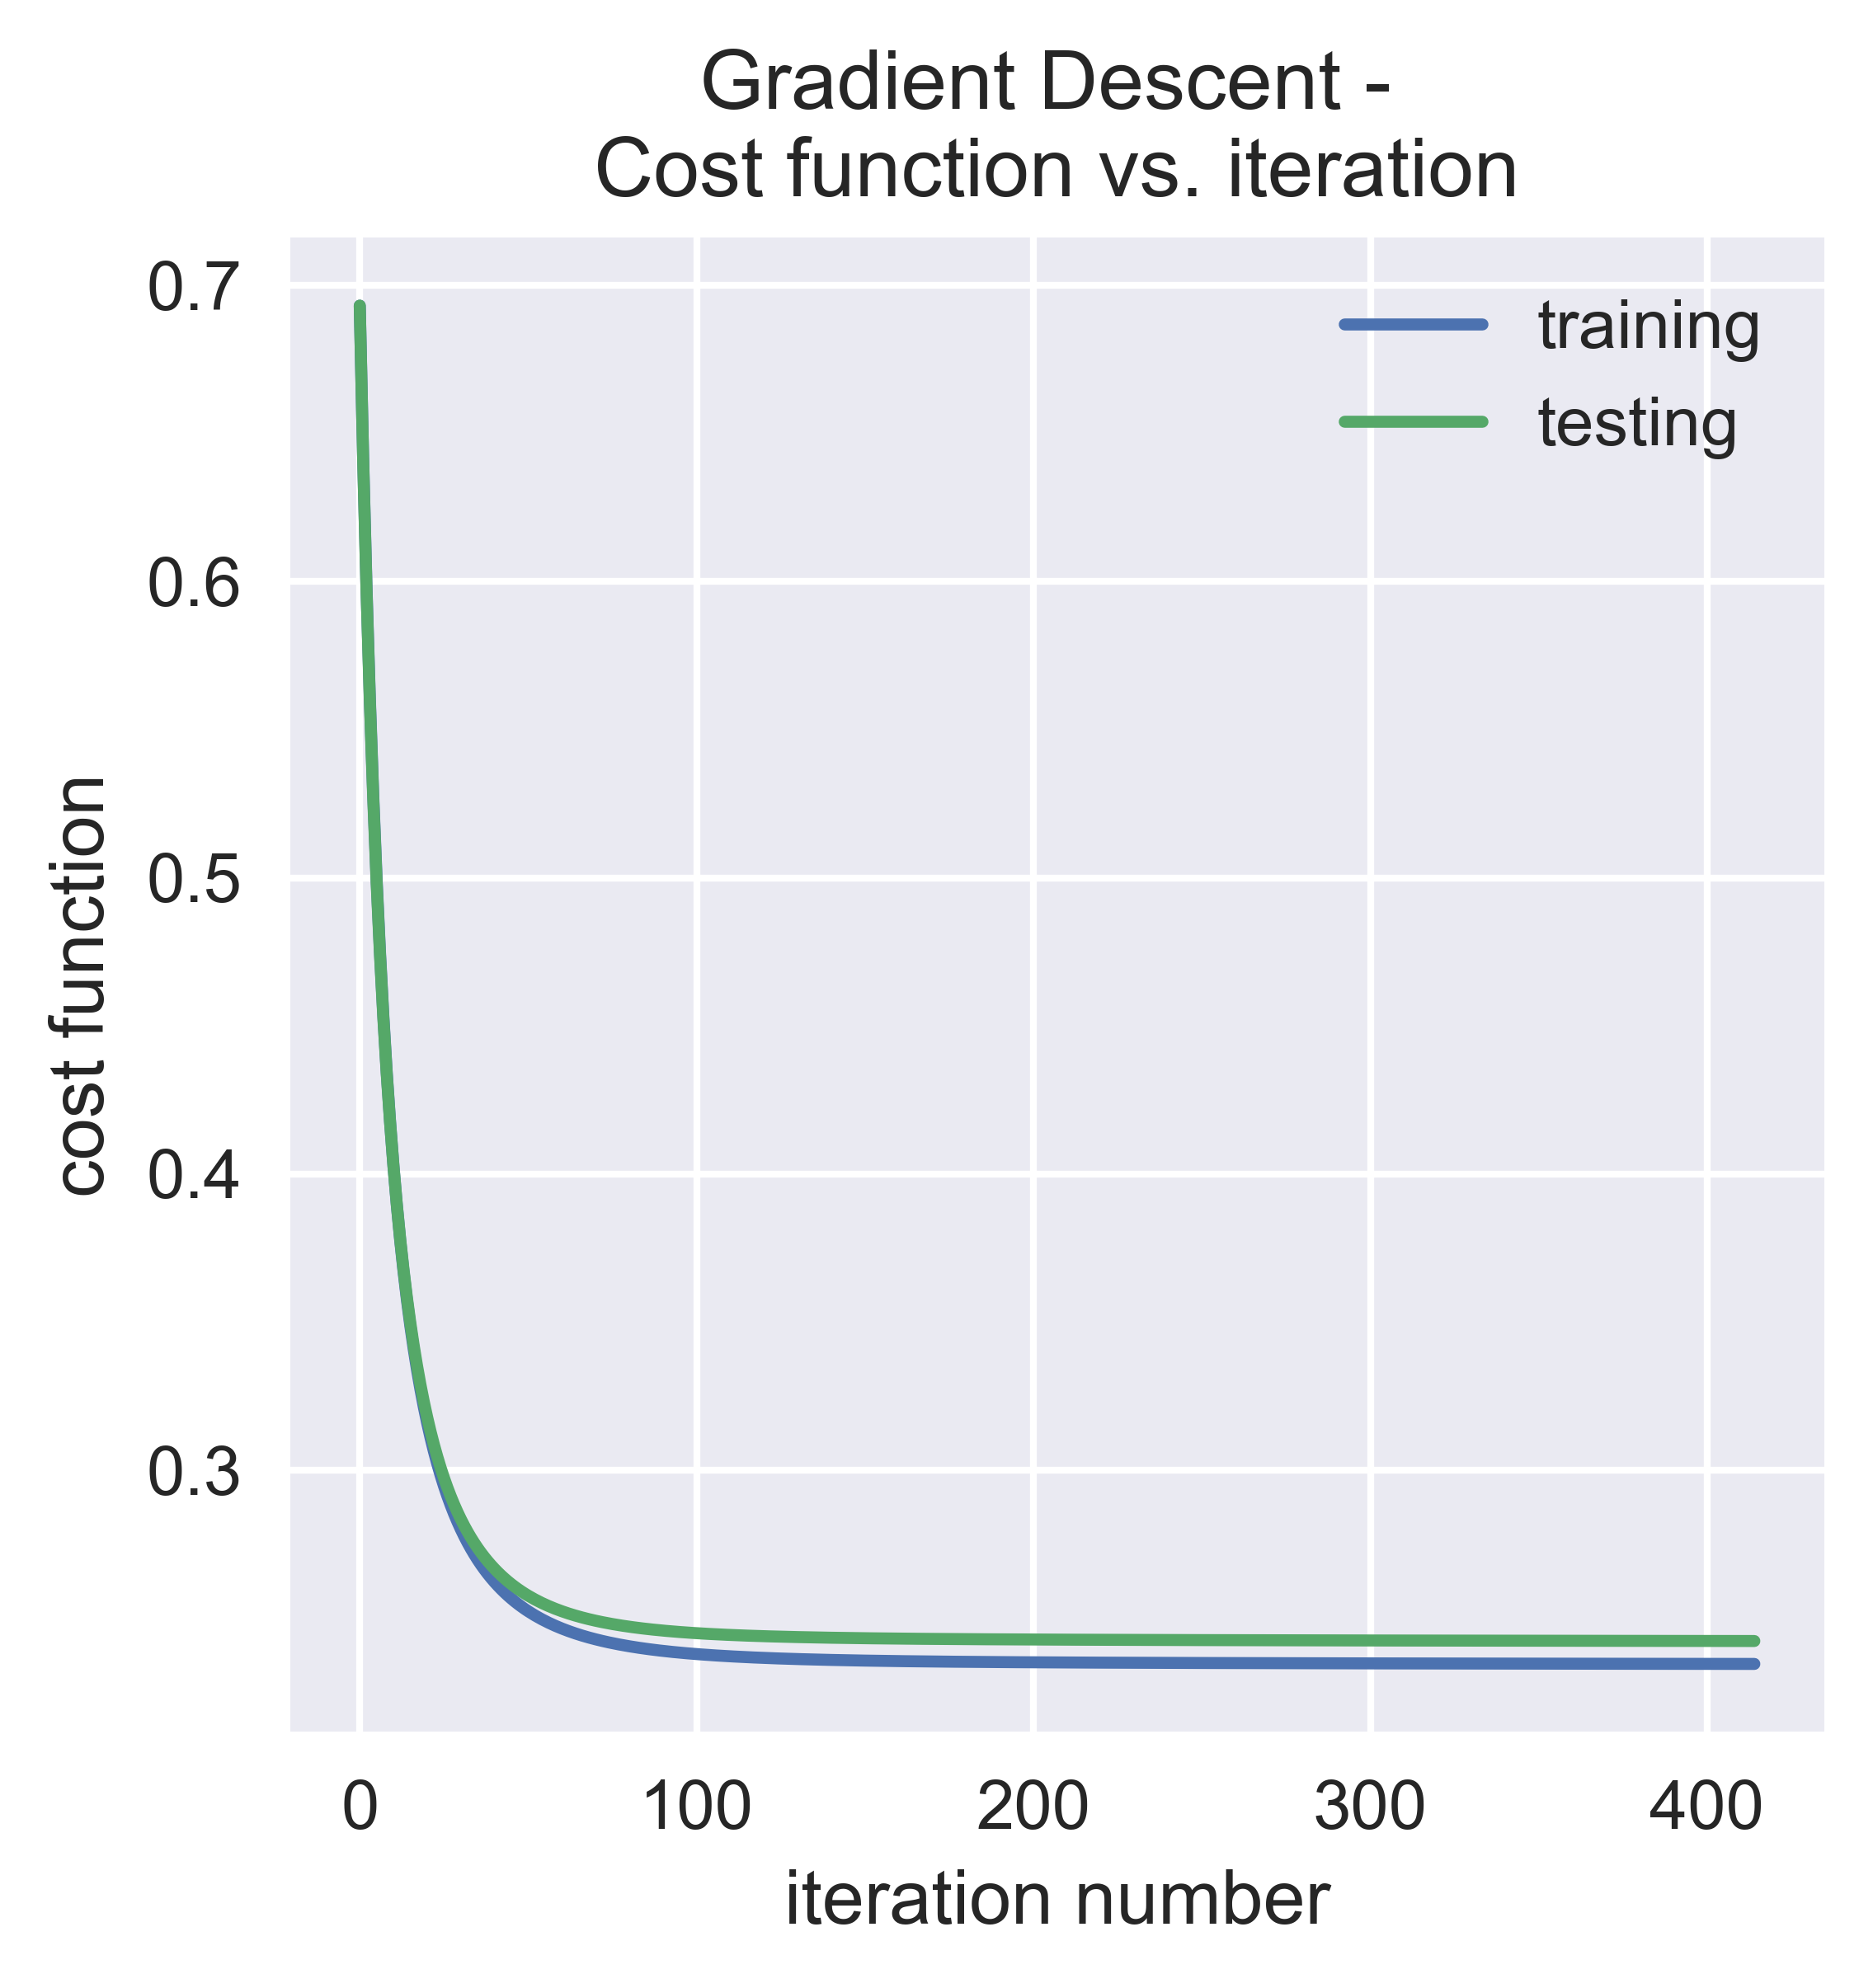

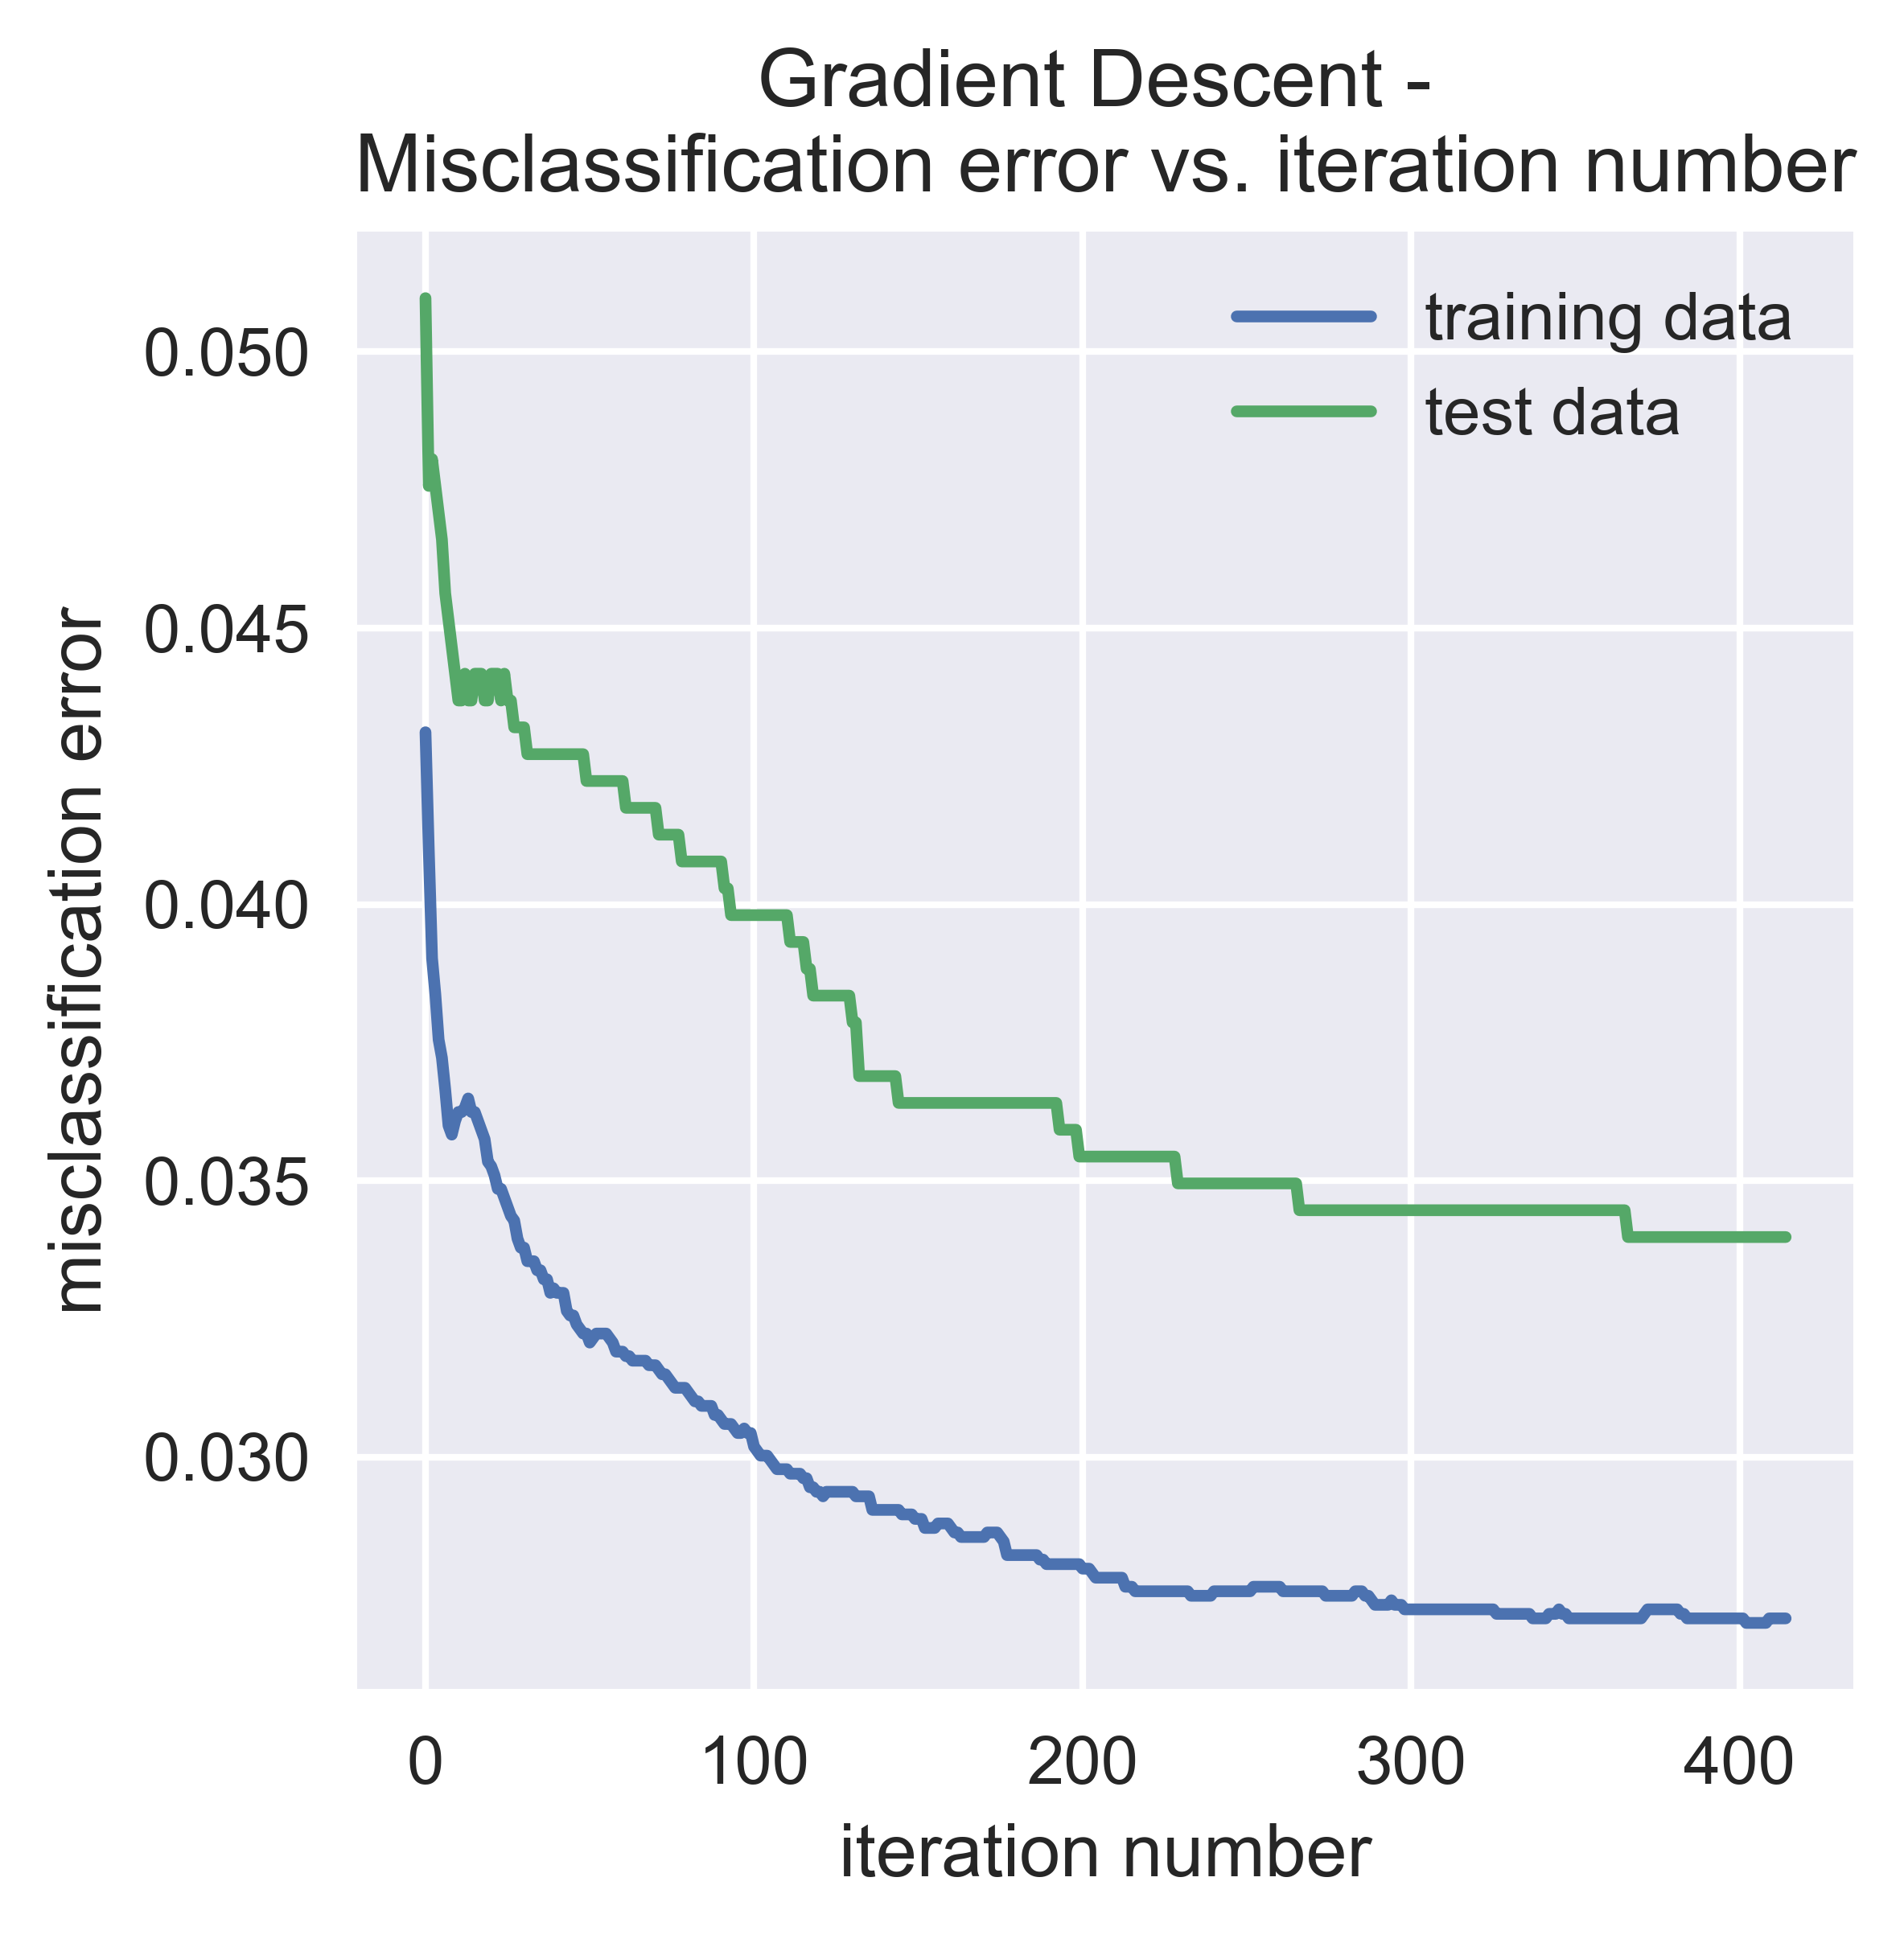

In [47]:
plot_objective_train_test(k_vec,j_train_vec,j_test_vec,train_classify_vec,test_classify_vec,'Gradient Descent - \n')

### stochastic gradient descent - 1 example

In [48]:
batch_size = 1
j_train_vec,j_test_vec,w_vec,b_vec,k_vec,test_classify_vec,train_classify_vec = SGD(x_train_c,labels_train_c,x_test_c,labels_test_c,lambda_val,batch_size)

the value of j train is 0.6931471805599452
the value of j train is 0.7198338033508097
the value of j train is 0.5108317725196523
the value of j train is 0.5335321725349298
the value of j train is 0.5882364557176586
the value of j train is 0.6252574708677106
the value of j train is 0.7013884150469302
the value of j train is 0.36920732556470887
the value of j train is 0.3610457273757561
the value of j train is 0.35938708473978564
the value of j train is 0.3368272573175279
the value of j train is 0.5013170720658193
the value of j train is 0.5214734809631661
the value of j train is 0.5236726121006139
the value of j train is 0.46325820113442806
the value of j train is 0.3726774374560138
the value of j train is 0.37925984231937415
the value of j train is 0.36689593983079993
the value of j train is 0.3726882053129772
the value of j train is 0.36564247439438197
the value of j train is 0.37427172011510124
the value of j train is 0.43178690177187523
the value of j train is 0.3232284911434284
the

the value of j train is 0.2711069304325176
the value of j train is 0.2747064891481931
the value of j train is 0.2747614454446246
the value of j train is 0.27528462399492054
the value of j train is 0.25911505106805743
the value of j train is 0.2632871612100404
the value of j train is 0.26059130424930704
the value of j train is 0.2575020418943912
the value of j train is 0.2544300411281714
the value of j train is 0.2760057699560655
the value of j train is 0.2588866281835834
the value of j train is 0.2589645062360023
the value of j train is 0.25735347172616757
the value of j train is 0.25825400610511934
the value of j train is 0.25414608415780165
the value of j train is 0.2591851168854834
the value of j train is 0.26123195568214075
the value of j train is 0.26390667716931554
the value of j train is 0.26741626148589187
the value of j train is 0.276968774831755
the value of j train is 0.28093517058700856
the value of j train is 0.28219483448418103
the value of j train is 0.27039318640414356


the value of j train is 0.26417463766516874
the value of j train is 0.2545663337496005
the value of j train is 0.2561317008726296
the value of j train is 0.26671250492831344
the value of j train is 0.26163644831890925
the value of j train is 0.2575138272958496
the value of j train is 0.25312608266789394
the value of j train is 0.25223887846173965
the value of j train is 0.314126879250194
the value of j train is 0.28465081185643165
the value of j train is 0.26922198858785273
the value of j train is 0.27386175353498543
the value of j train is 0.2695430505527549
the value of j train is 0.2620374836764875
the value of j train is 0.26351356552848254
the value of j train is 0.2861883847259292
the value of j train is 0.2859556717776179
the value of j train is 0.28642428205957204
the value of j train is 0.28655525621499794
the value of j train is 0.27520841340928504
the value of j train is 0.27928146745479865
the value of j train is 0.28314530444719466
the value of j train is 0.266895687274008

the value of j train is 0.2668796731355462
the value of j train is 0.2568311690278395
the value of j train is 0.2571204175751686
the value of j train is 0.25082753613309156
the value of j train is 0.2503596734619229
the value of j train is 0.2579195062068972
the value of j train is 0.2639660349212704
the value of j train is 0.26230729652413964
the value of j train is 0.2634147197211666
the value of j train is 0.2620004807176626
the value of j train is 0.2565172396807331
the value of j train is 0.2580943218964384
the value of j train is 0.2548715950831856
the value of j train is 0.25465676524729364
the value of j train is 0.2550198068761027
the value of j train is 0.2567787951271693
the value of j train is 0.25698048404210405
the value of j train is 0.25072527203769623
the value of j train is 0.2512318793804495
the value of j train is 0.2514904882278659
the value of j train is 0.2509378143710241
the value of j train is 0.25192839254675764
the value of j train is 0.25118691248576464
the 

the value of j train is 0.2537872253248633
the value of j train is 0.24963103133238976
the value of j train is 0.24982402219071995
the value of j train is 0.24876718637863576
the value of j train is 0.24838011936920024
the value of j train is 0.2500446033841436
the value of j train is 0.2485274990711524
the value of j train is 0.2520426444126459
the value of j train is 0.24924837006891526
the value of j train is 0.25135428885183336
the value of j train is 0.2503142400102776
the value of j train is 0.25306369618700086
the value of j train is 0.25067967231630284
the value of j train is 0.3317637346664991
the value of j train is 0.3442243419089318
the value of j train is 0.3446175993600177
the value of j train is 0.35477582713584754
the value of j train is 0.2825977816293178
the value of j train is 0.28751445217778715
the value of j train is 0.28755270754913453
the value of j train is 0.29043433117816353
the value of j train is 0.2596853427826478
the value of j train is 0.2553463312463193

the value of j train is 0.24997780771223033
the value of j train is 0.25449520470819637
the value of j train is 0.26600800767000404
the value of j train is 0.2666785589851795
the value of j train is 0.25550566826816257
the value of j train is 0.27168462761093093
the value of j train is 0.27385676185997626
the value of j train is 0.27601668671369295
the value of j train is 0.2761164022423697
the value of j train is 0.27733464883837516
the value of j train is 0.2719655370583012
the value of j train is 0.2730189639167153
the value of j train is 0.28806441042409703
the value of j train is 0.2736815550829411
the value of j train is 0.26406656372659265
the value of j train is 0.2607317688676203
the value of j train is 0.2580684599628392
the value of j train is 0.2600122026659193
the value of j train is 0.25076817463634676
the value of j train is 0.2508455331649838
the value of j train is 0.2501465002491214
the value of j train is 0.2561885737920716
the value of j train is 0.2561694860066606


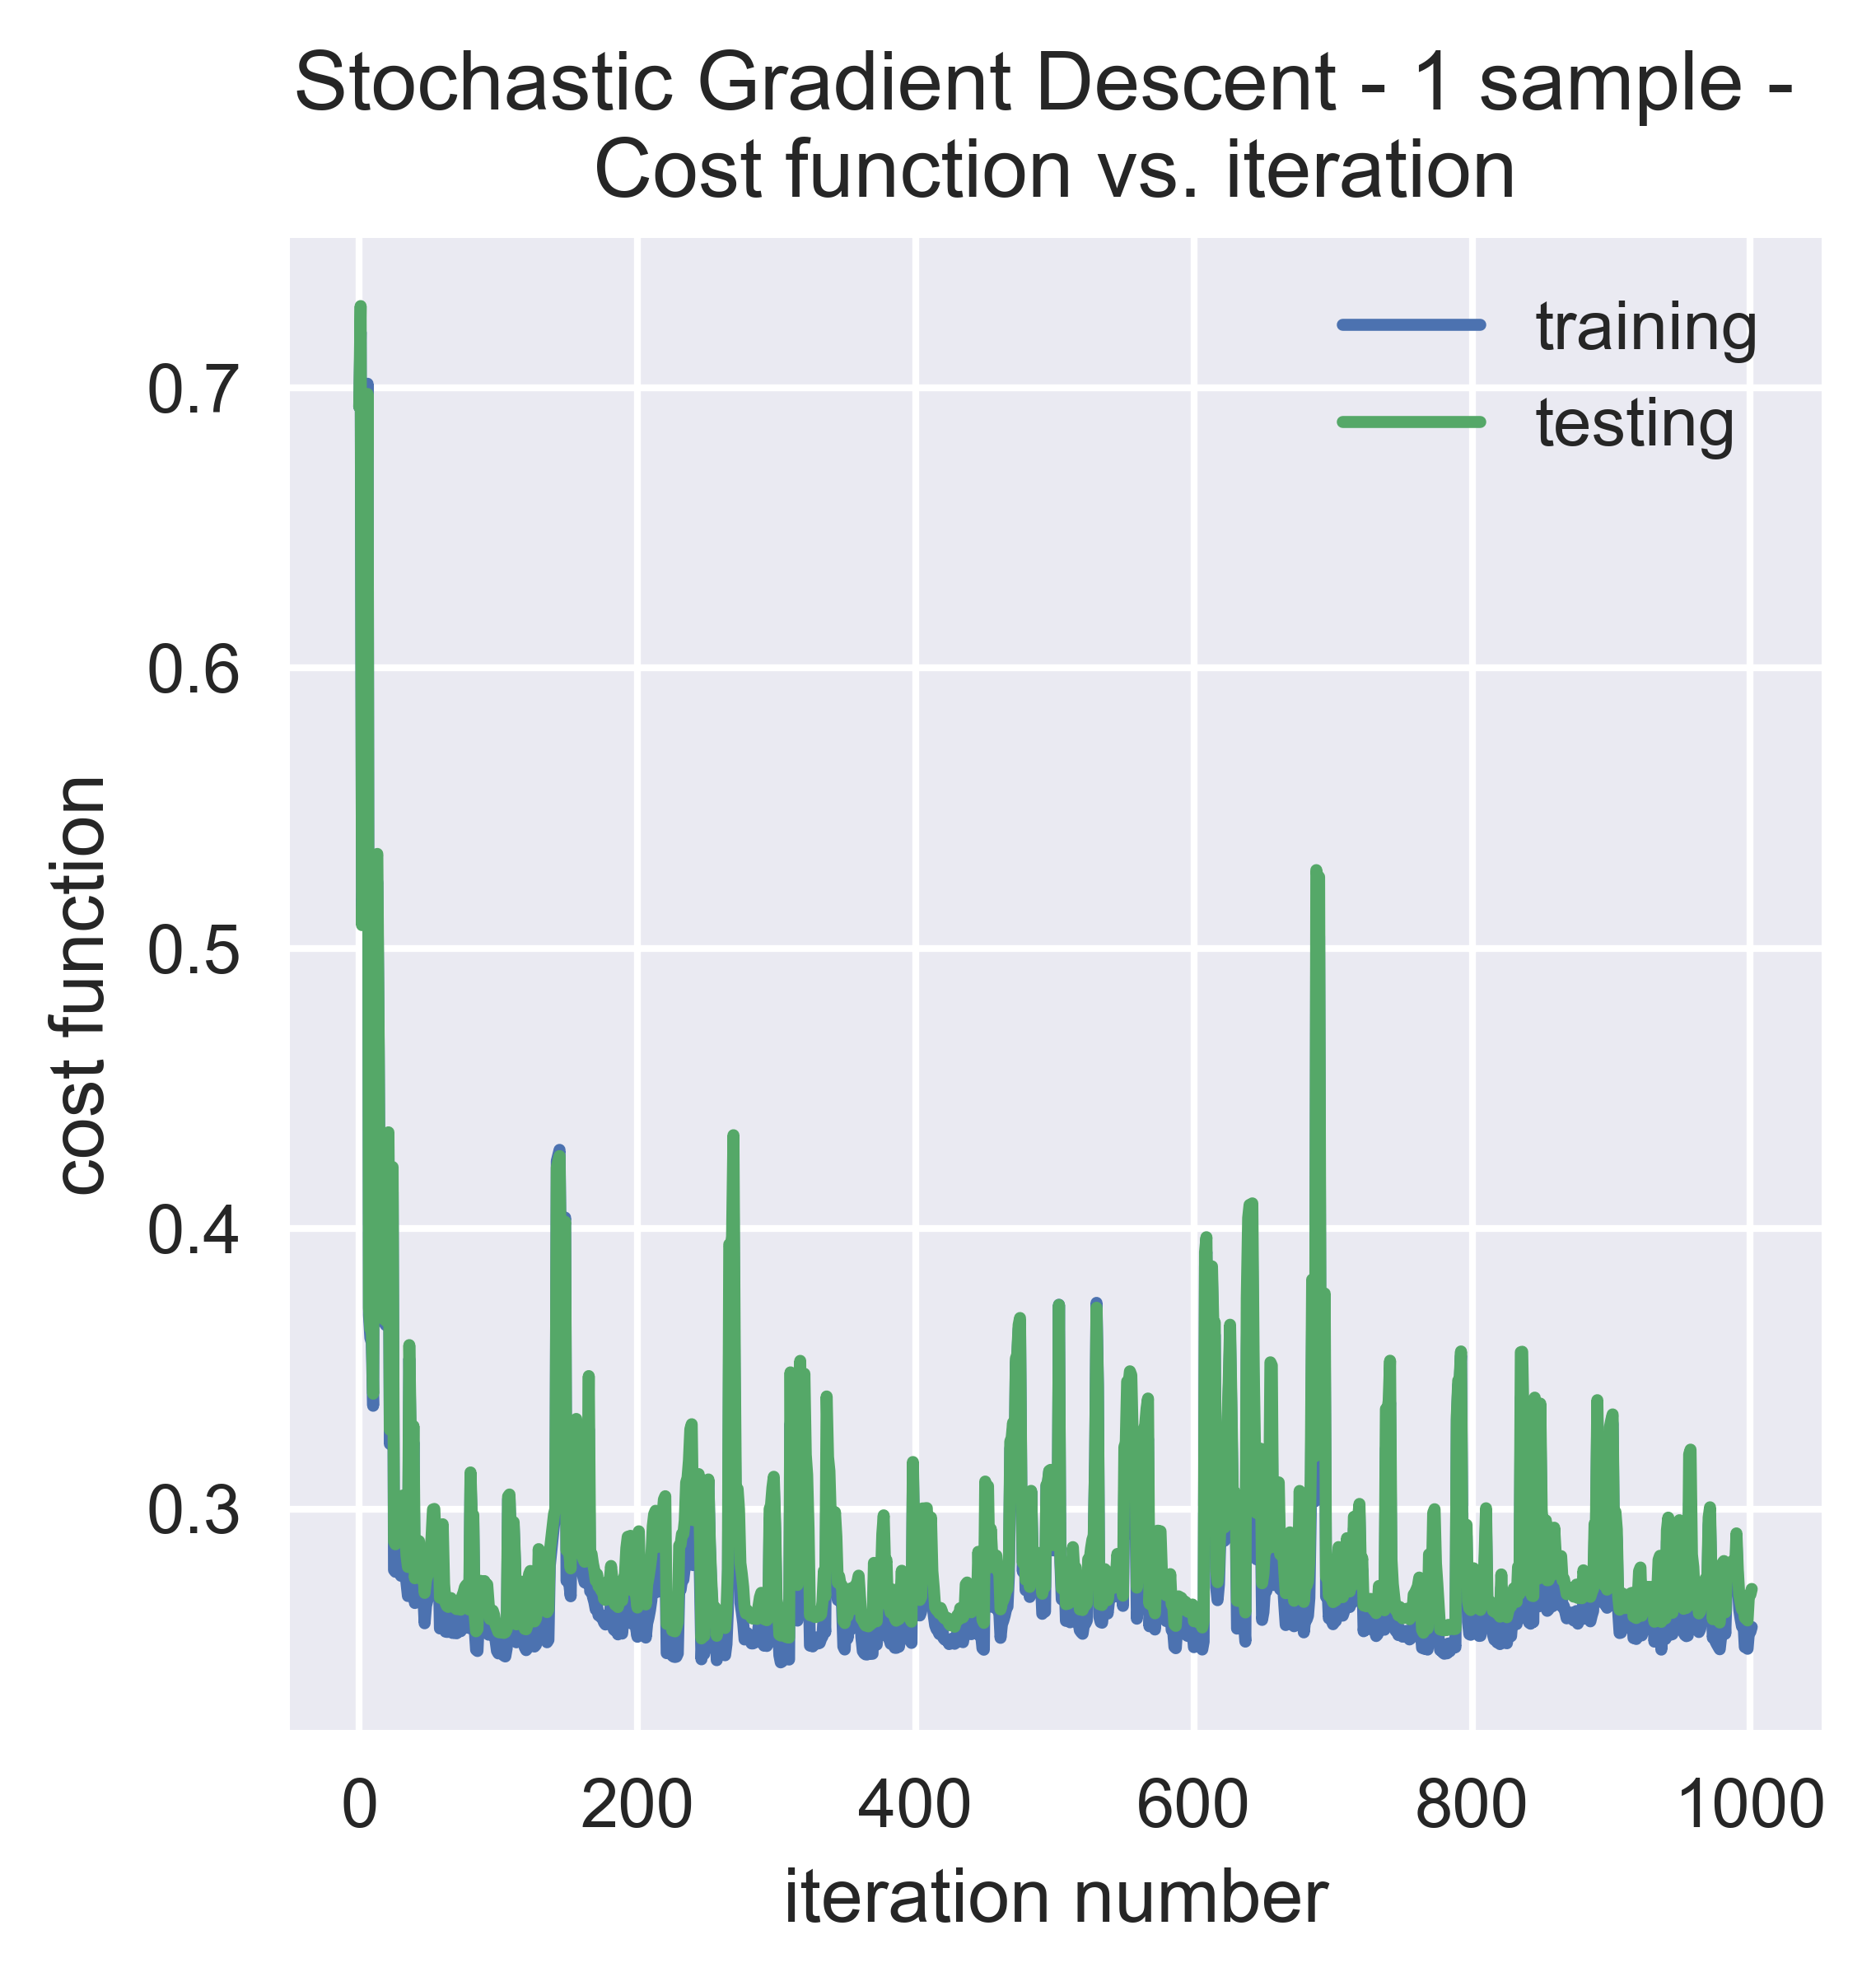

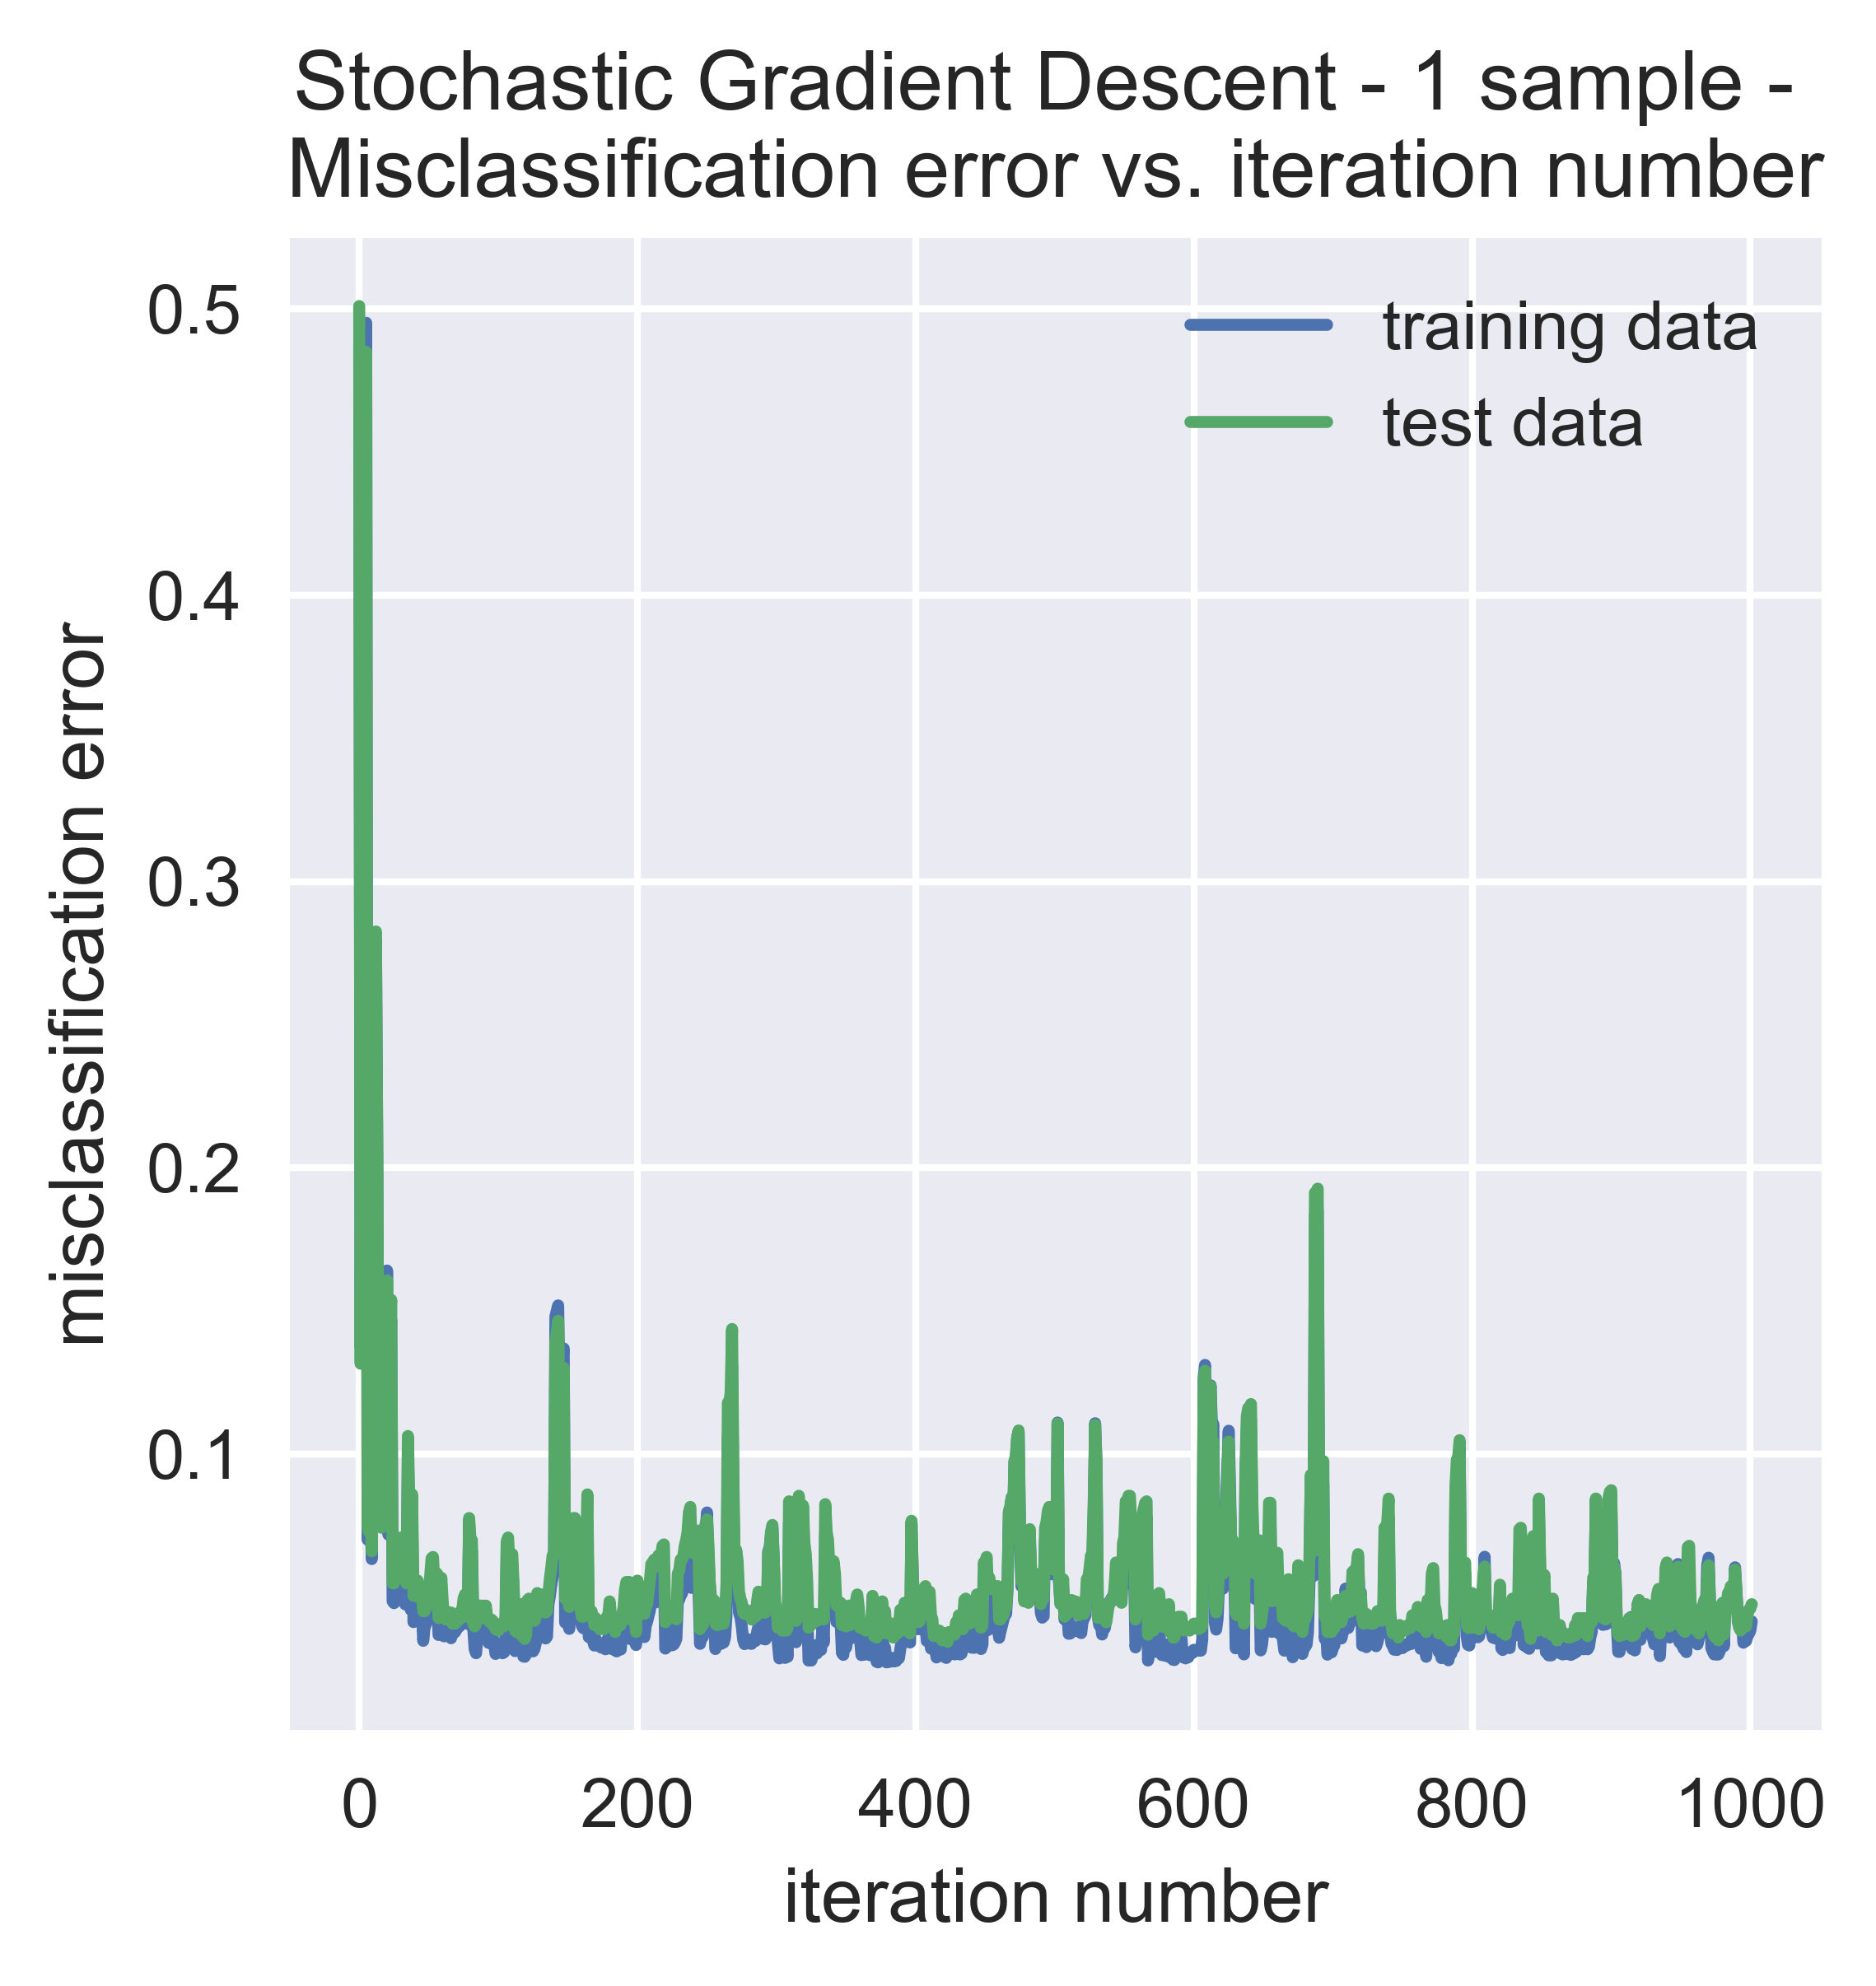

In [49]:
plot_objective_train_test(k_vec,j_train_vec,j_test_vec,train_classify_vec,test_classify_vec,'Stochastic Gradient Descent - 1 sample - \n')

### stochastic gradient descent - batch size 100

In [50]:
batch_size = 100 
j_train_vec,j_test_vec,w_vec,b_vec,k_vec,test_classify_vec,train_classify_vec = SGD(x_train_c,labels_train_c,x_test_c,labels_test_c,lambda_val,batch_size)

the value of j train is 0.6931471805599452
the value of j train is 0.6120082973566925
the value of j train is 0.5435086248409993
the value of j train is 0.4983719962738398
the value of j train is 0.45608324528210414
the value of j train is 0.4289376617275252
the value of j train is 0.40287830153513626
the value of j train is 0.3804359653018529
the value of j train is 0.36359963546598856
the value of j train is 0.3486048399448296
the value of j train is 0.3369253391612845
the value of j train is 0.325118023152933
the value of j train is 0.3157863545574038
the value of j train is 0.3068900419787006
the value of j train is 0.3001135629418059
the value of j train is 0.29359565202696974
the value of j train is 0.287858912767322
the value of j train is 0.28311643794715774
the value of j train is 0.2787272679744538
the value of j train is 0.2751907850034822
the value of j train is 0.2717428456012268
the value of j train is 0.2693960428578688
the value of j train is 0.2663228507321272
the valu

the value of j train is 0.23496611673585474
the value of j train is 0.235005846866397
the value of j train is 0.2349687315064291
the value of j train is 0.23497744054036532
the value of j train is 0.23499494434630444
the value of j train is 0.23507626842873708
the value of j train is 0.23502318323341442
the value of j train is 0.23497992952447788
the value of j train is 0.23503345081630467
the value of j train is 0.23499695562997078
the value of j train is 0.23498807557059673
the value of j train is 0.23511689539532082
the value of j train is 0.23494533846713828
the value of j train is 0.23501593041753532
the value of j train is 0.23497381972805725
the value of j train is 0.23509543383697964
the value of j train is 0.23491483769773985
the value of j train is 0.234886770434619
the value of j train is 0.2348304722464487
the value of j train is 0.2348866027979447
the value of j train is 0.2348424768620223
the value of j train is 0.2348883109992092
the value of j train is 0.234951807535754

the value of j train is 0.23452694777375122
the value of j train is 0.2344553608053611
the value of j train is 0.23454479842524134
the value of j train is 0.23466027905219178
the value of j train is 0.2347169540714067
the value of j train is 0.2345935891686024
the value of j train is 0.23452529422516968
the value of j train is 0.23468257108314083
the value of j train is 0.23493079313805532
the value of j train is 0.23479384078811258
the value of j train is 0.23451319068594365
the value of j train is 0.23457831473781732
the value of j train is 0.23479930057940168
the value of j train is 0.23468285970552977
the value of j train is 0.23452728633881892
the value of j train is 0.23448995789186688
the value of j train is 0.23455031891894085
the value of j train is 0.23445828719746137
the value of j train is 0.23453843869969515
the value of j train is 0.2344508037247292
the value of j train is 0.23475077646141895
the value of j train is 0.23448972828879205
the value of j train is 0.2345175247

the value of j train is 0.23448257934610917
the value of j train is 0.2347220855436874
the value of j train is 0.23480246195238796
the value of j train is 0.2353944732077415
the value of j train is 0.23466216338578735
the value of j train is 0.23465882005245953
the value of j train is 0.23477331386928976
the value of j train is 0.23459126008365264
the value of j train is 0.23459716257567897
the value of j train is 0.23421343041147735
the value of j train is 0.23438343924699392
the value of j train is 0.2343125163813528
the value of j train is 0.23429335311821345
the value of j train is 0.2342214809593863
the value of j train is 0.23422839440197707
the value of j train is 0.23426241319774582
the value of j train is 0.23426950923189913
the value of j train is 0.23426429598677403
the value of j train is 0.23434902828663853
the value of j train is 0.2342918076774853
the value of j train is 0.2342287844340484
the value of j train is 0.23433635251060564
the value of j train is 0.234278535467

the value of j train is 0.23403405448422307
the value of j train is 0.23400513236818565
the value of j train is 0.23402025219760497
the value of j train is 0.23437880465428587
the value of j train is 0.23442701141482958
the value of j train is 0.23449144884550918
the value of j train is 0.2341430169172585
the value of j train is 0.2341580355187938
the value of j train is 0.23398476059476933
the value of j train is 0.23408486384926477
the value of j train is 0.23414227831205842
the value of j train is 0.2340593486074401
the value of j train is 0.23412735478765972
the value of j train is 0.23412278115576324
the value of j train is 0.23397063967083262
the value of j train is 0.23406799060436612
the value of j train is 0.2345190255895704
the value of j train is 0.2340034982171433
the value of j train is 0.23401101657963874
the value of j train is 0.23406379215591547
the value of j train is 0.23418544463759305
the value of j train is 0.23419722805143853
the value of j train is 0.23426344266

the value of j train is 0.23401186706296245
the value of j train is 0.23390837953769
the value of j train is 0.23384299306795905
the value of j train is 0.23389040445421178
the value of j train is 0.2338471491744467
the value of j train is 0.23386053884955063
the value of j train is 0.2341756839909785
the value of j train is 0.23393553906401215
the value of j train is 0.2340175830566385
the value of j train is 0.23416104421373843
the value of j train is 0.23409772222073388
the value of j train is 0.23387162928223476
the value of j train is 0.23388086407345798
the value of j train is 0.23394598721629747
the value of j train is 0.23419689737188448
the value of j train is 0.23462808036938165
the value of j train is 0.2347883864451598
the value of j train is 0.23462638216818205
the value of j train is 0.23476388174778032
the value of j train is 0.23507250305737282
the value of j train is 0.2355751602837529
the value of j train is 0.23477710848154
the value of j train is 0.23395566556320993

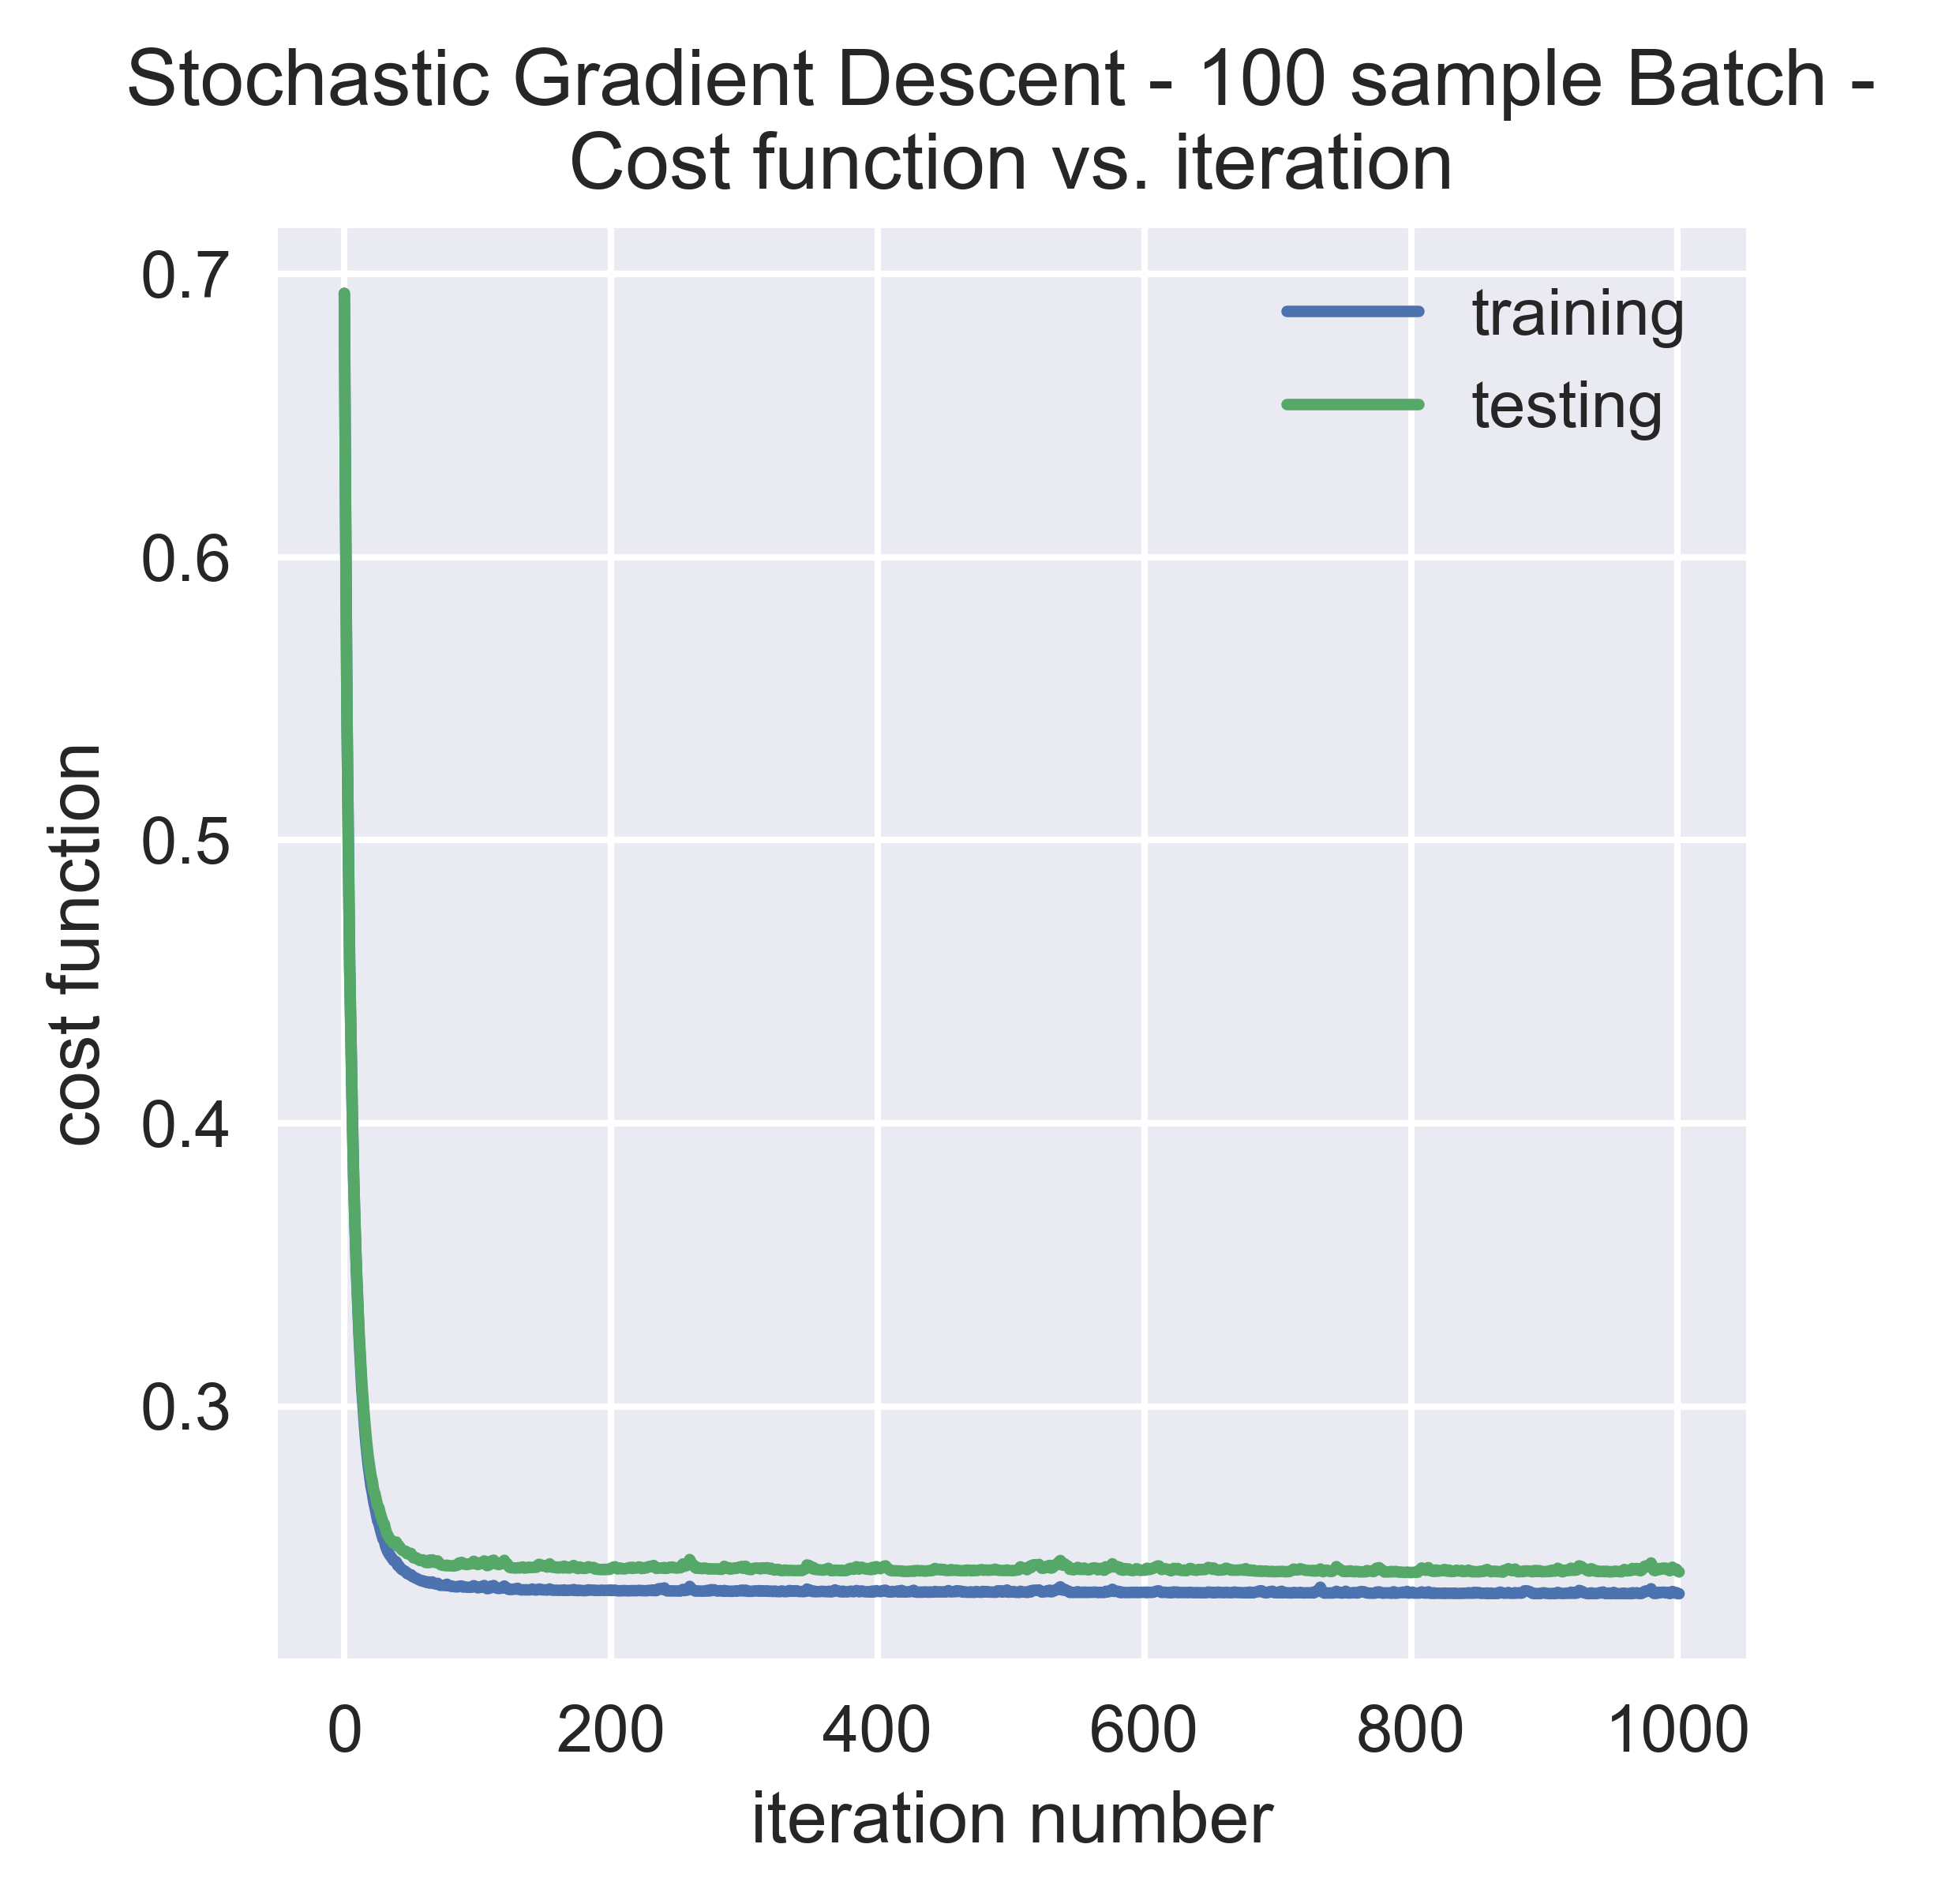

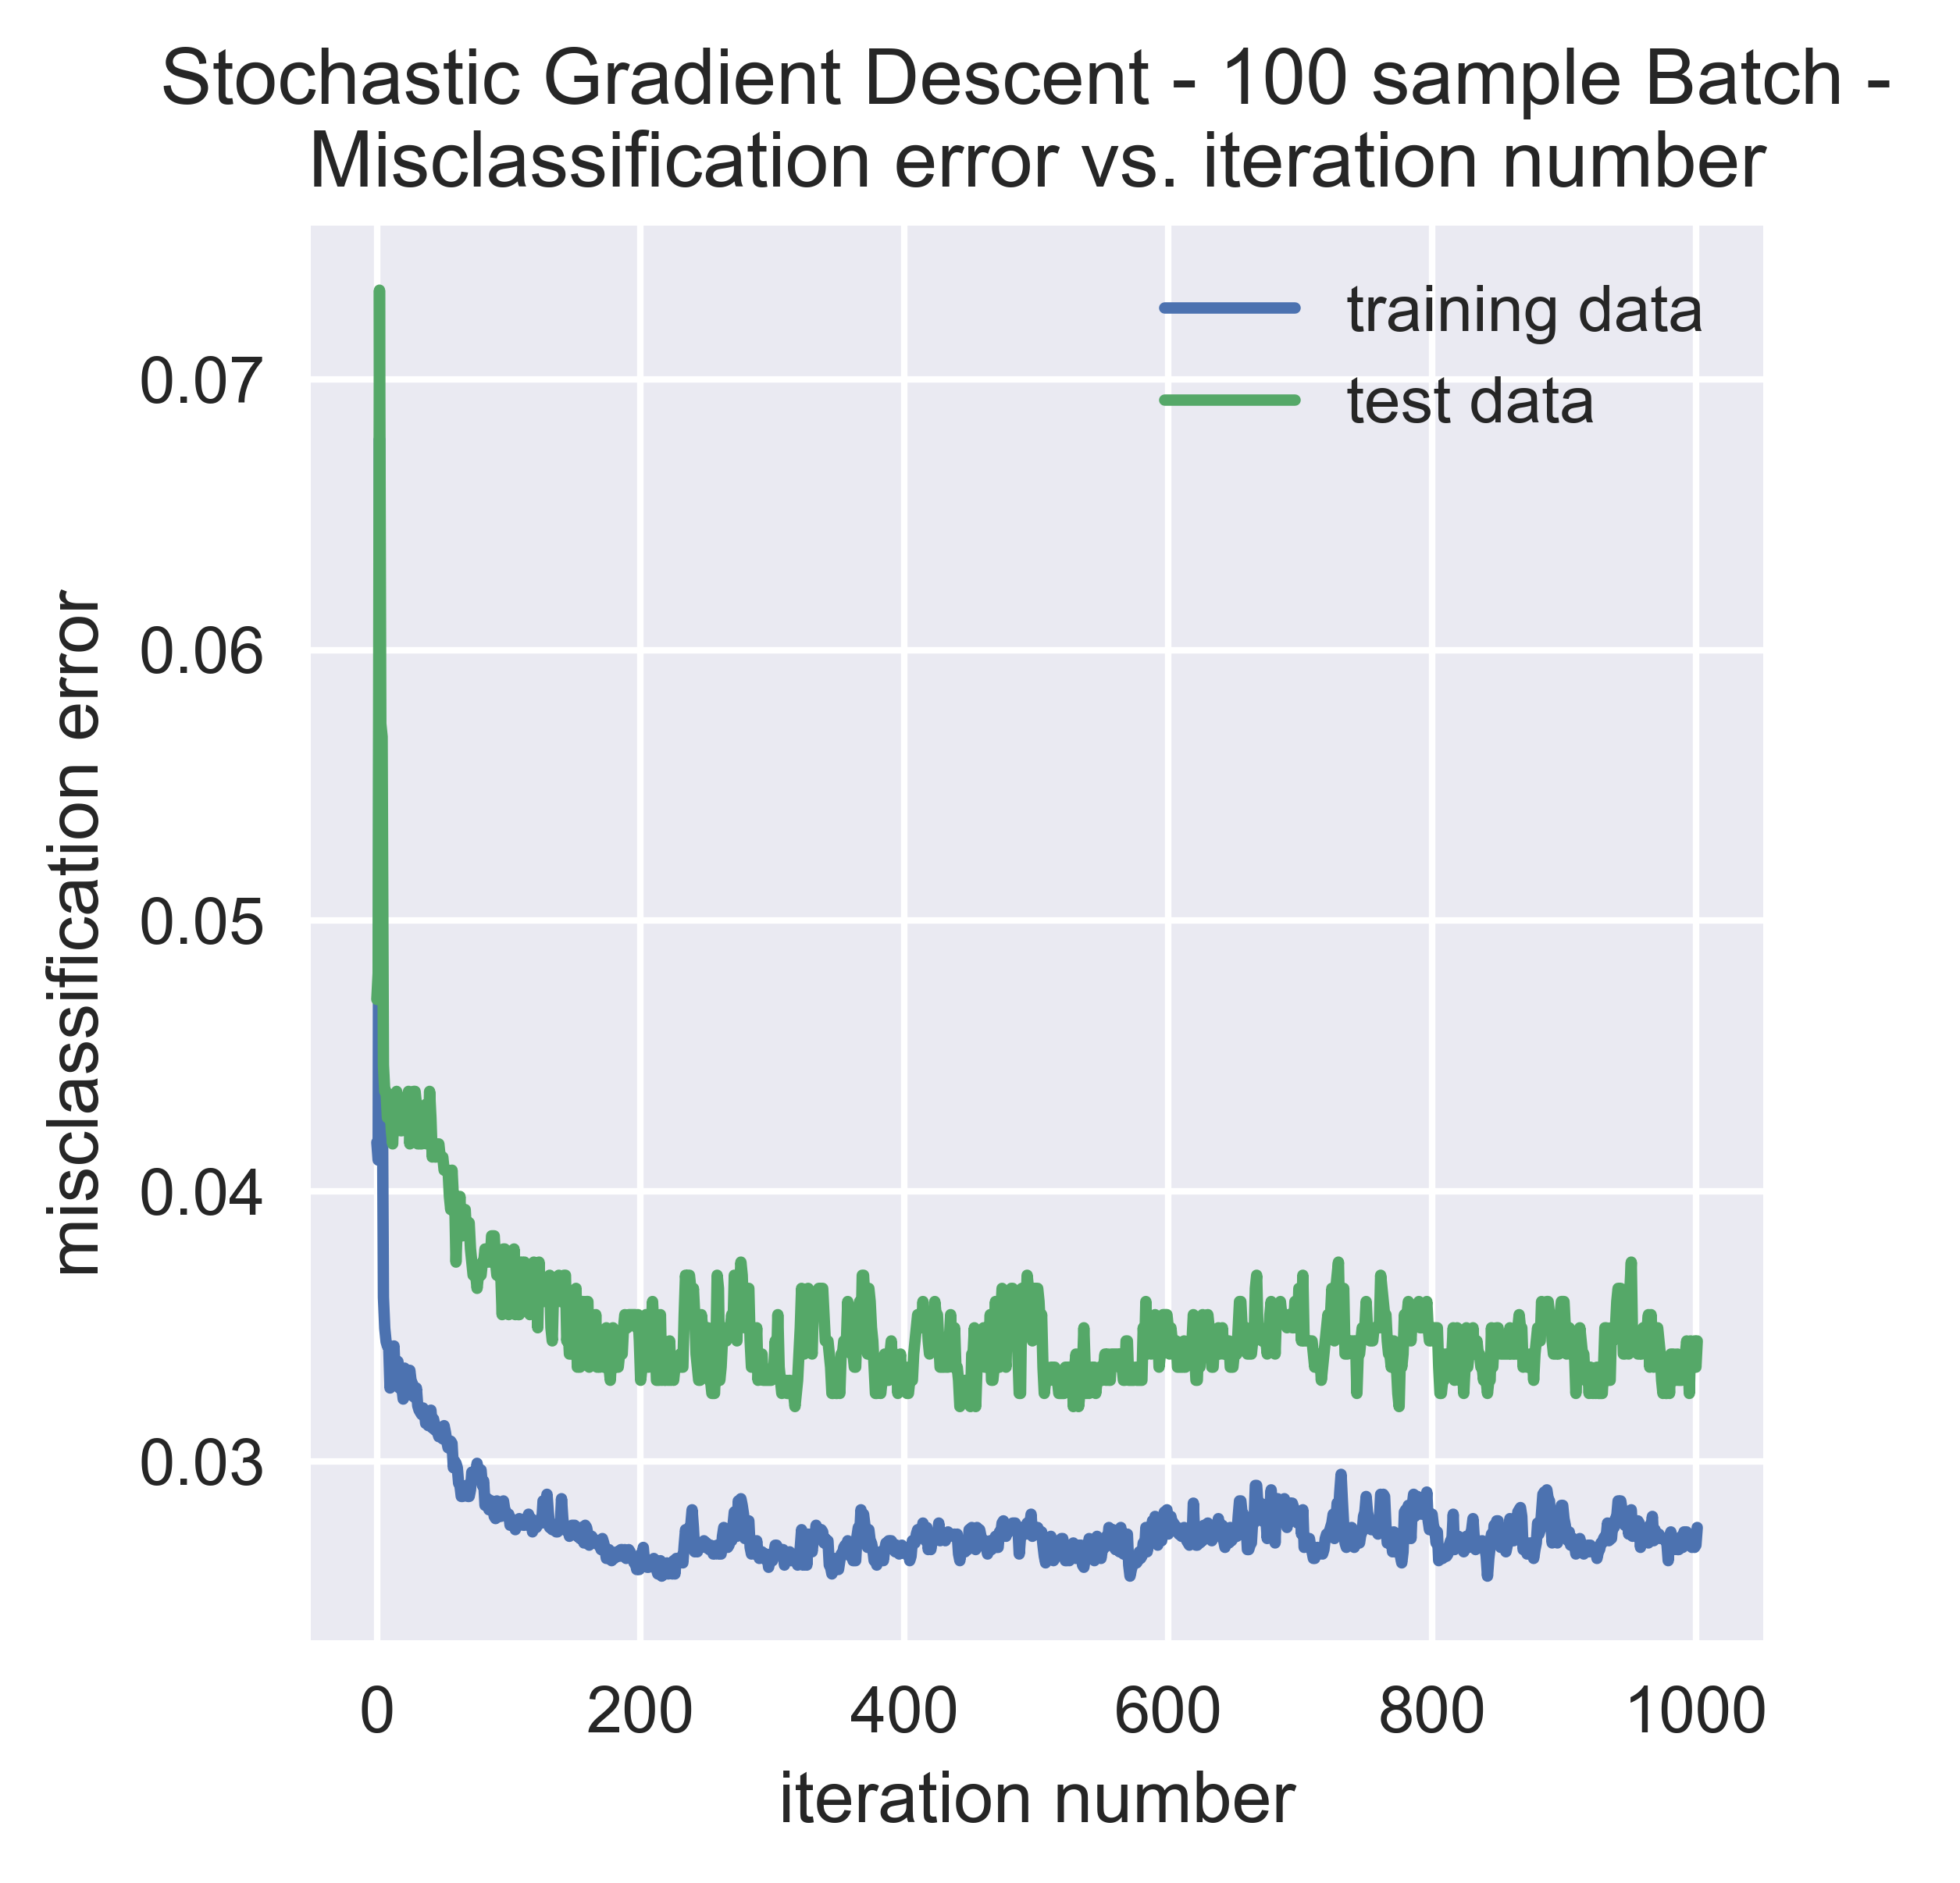

In [51]:
plot_objective_train_test(k_vec,j_train_vec,j_test_vec,train_classify_vec,test_classify_vec,'Stochastic Gradient Descent - 100 sample Batch - \n')

### newton's method 

In [19]:
j_train_vec,j_test_vec,w_vec,b_vec,k_vec,test_classify_vec,train_classify_vec = newton_method(x_train_c,labels_train_c,x_test_c,labels_test_c,lambda_val)

the value of j train is 0.6931471805599452
the value of j train is 0.27352301728320094


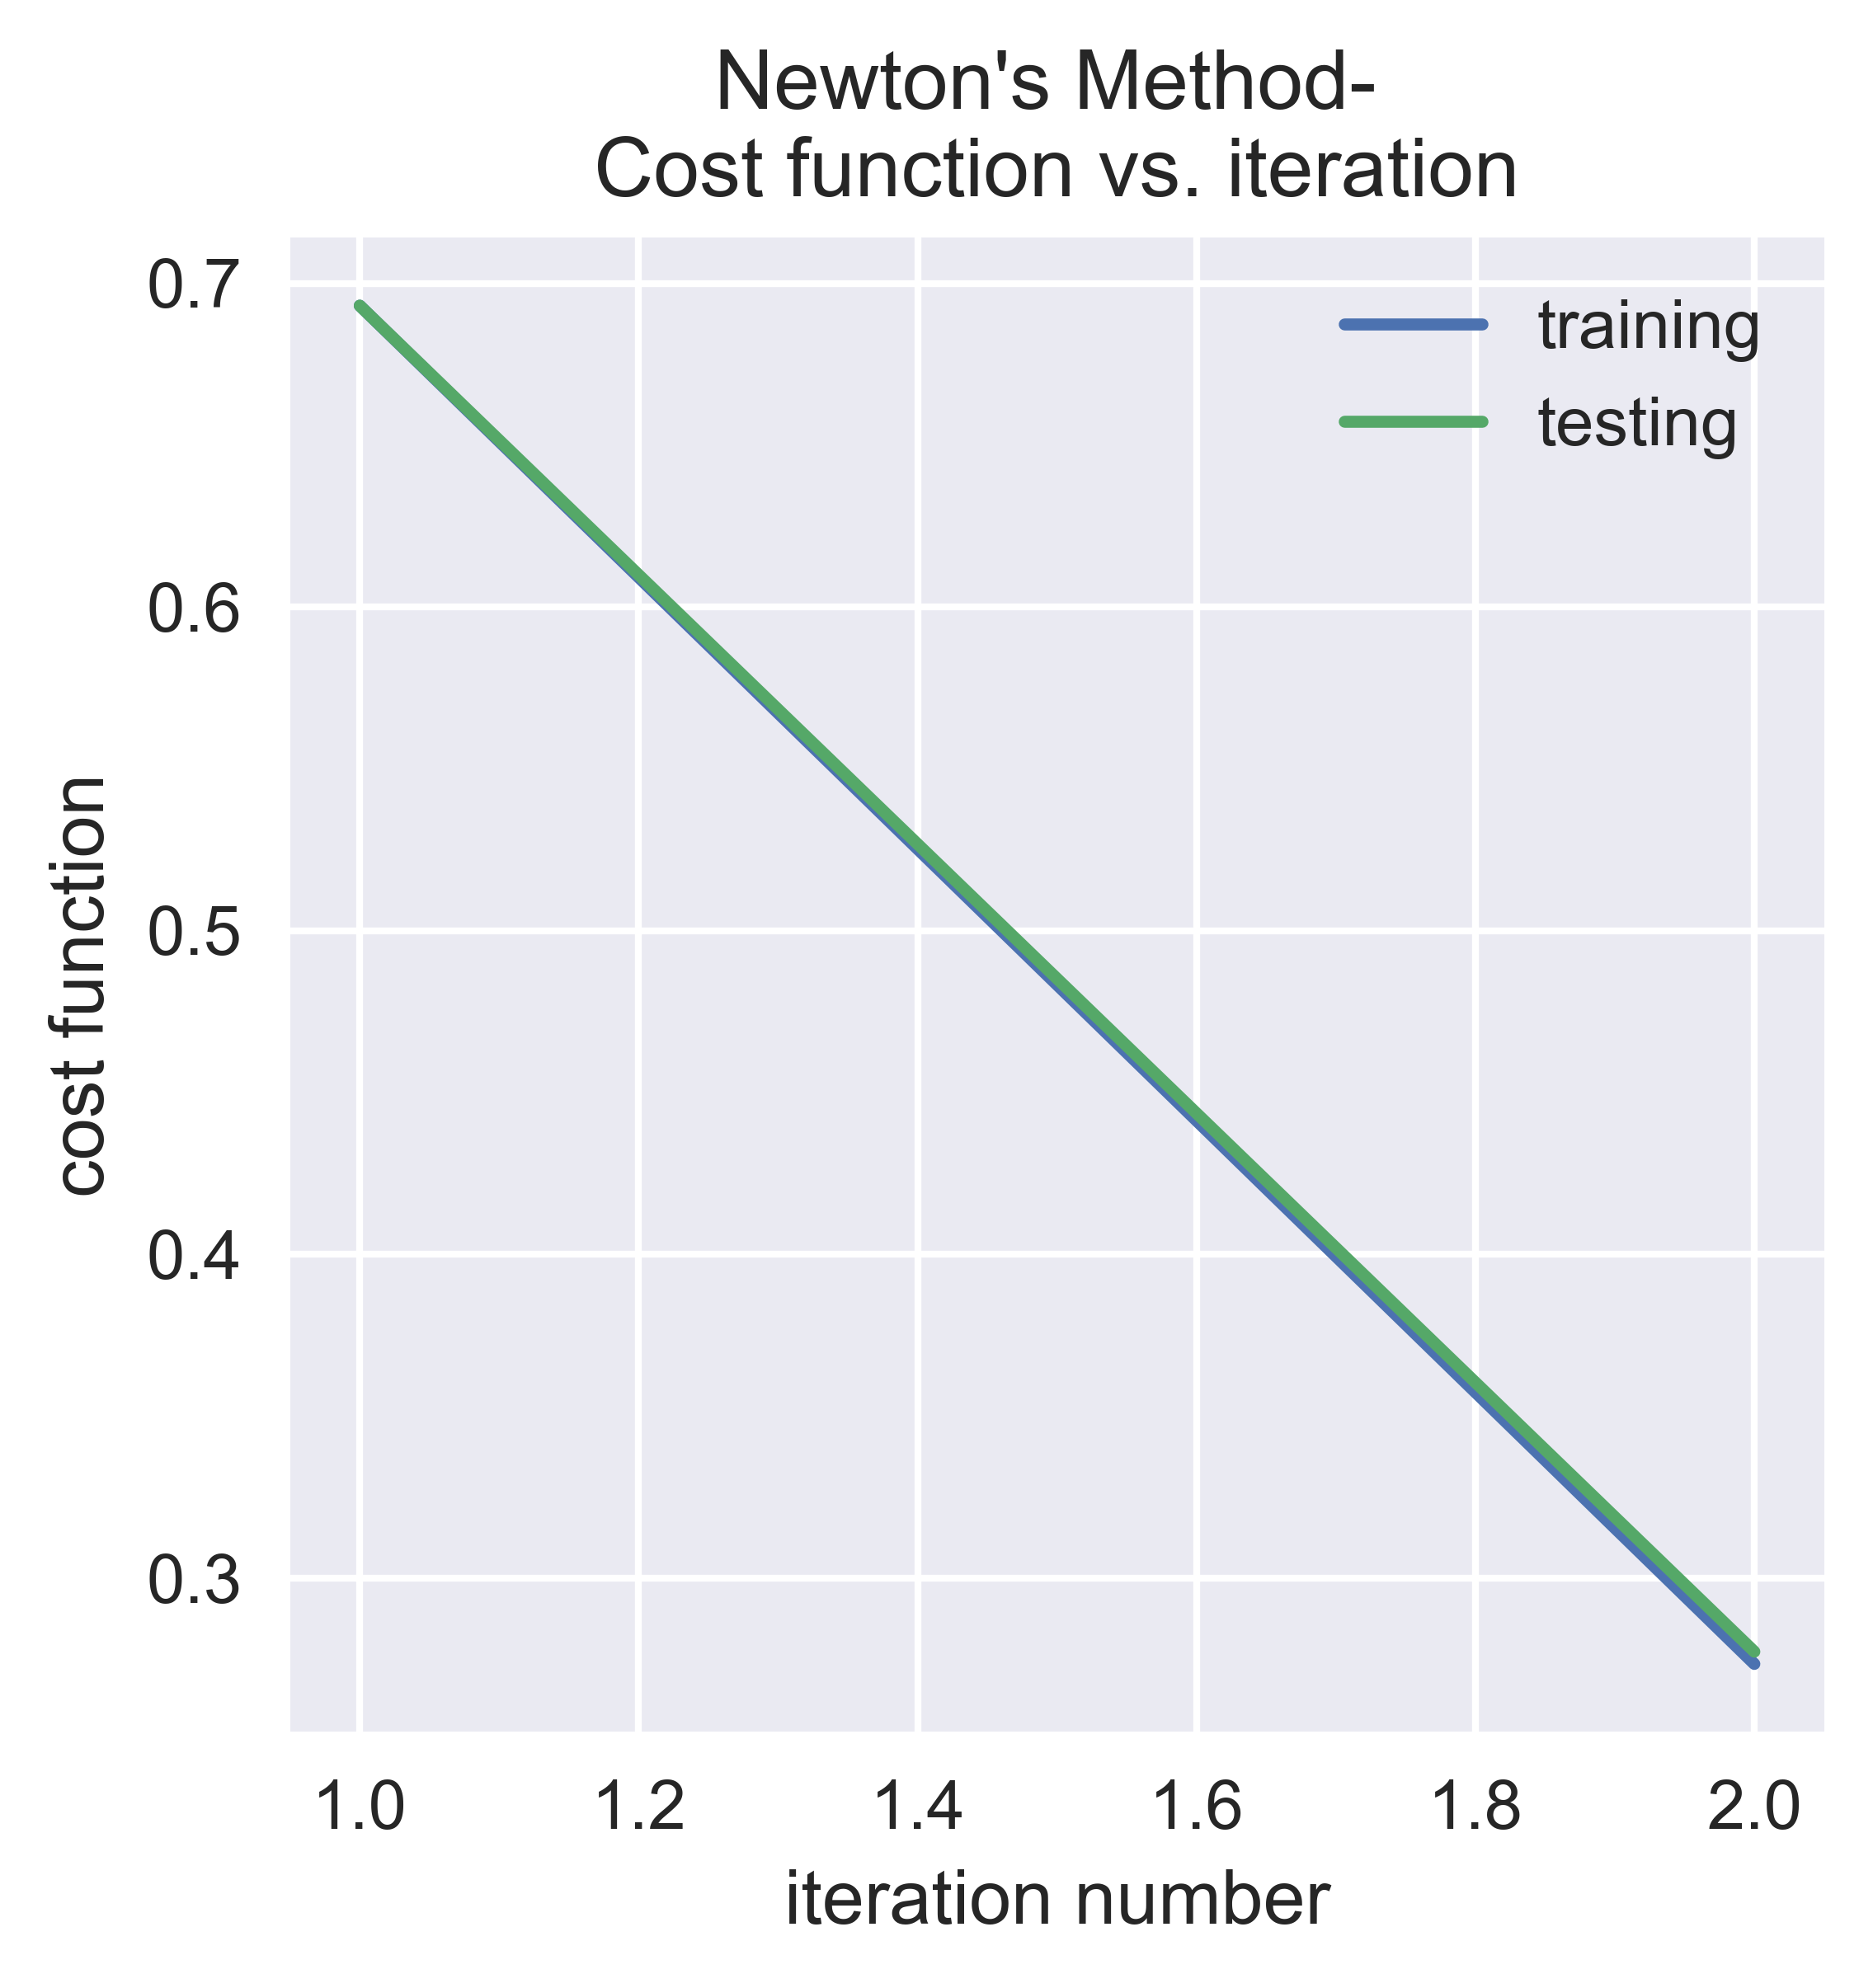

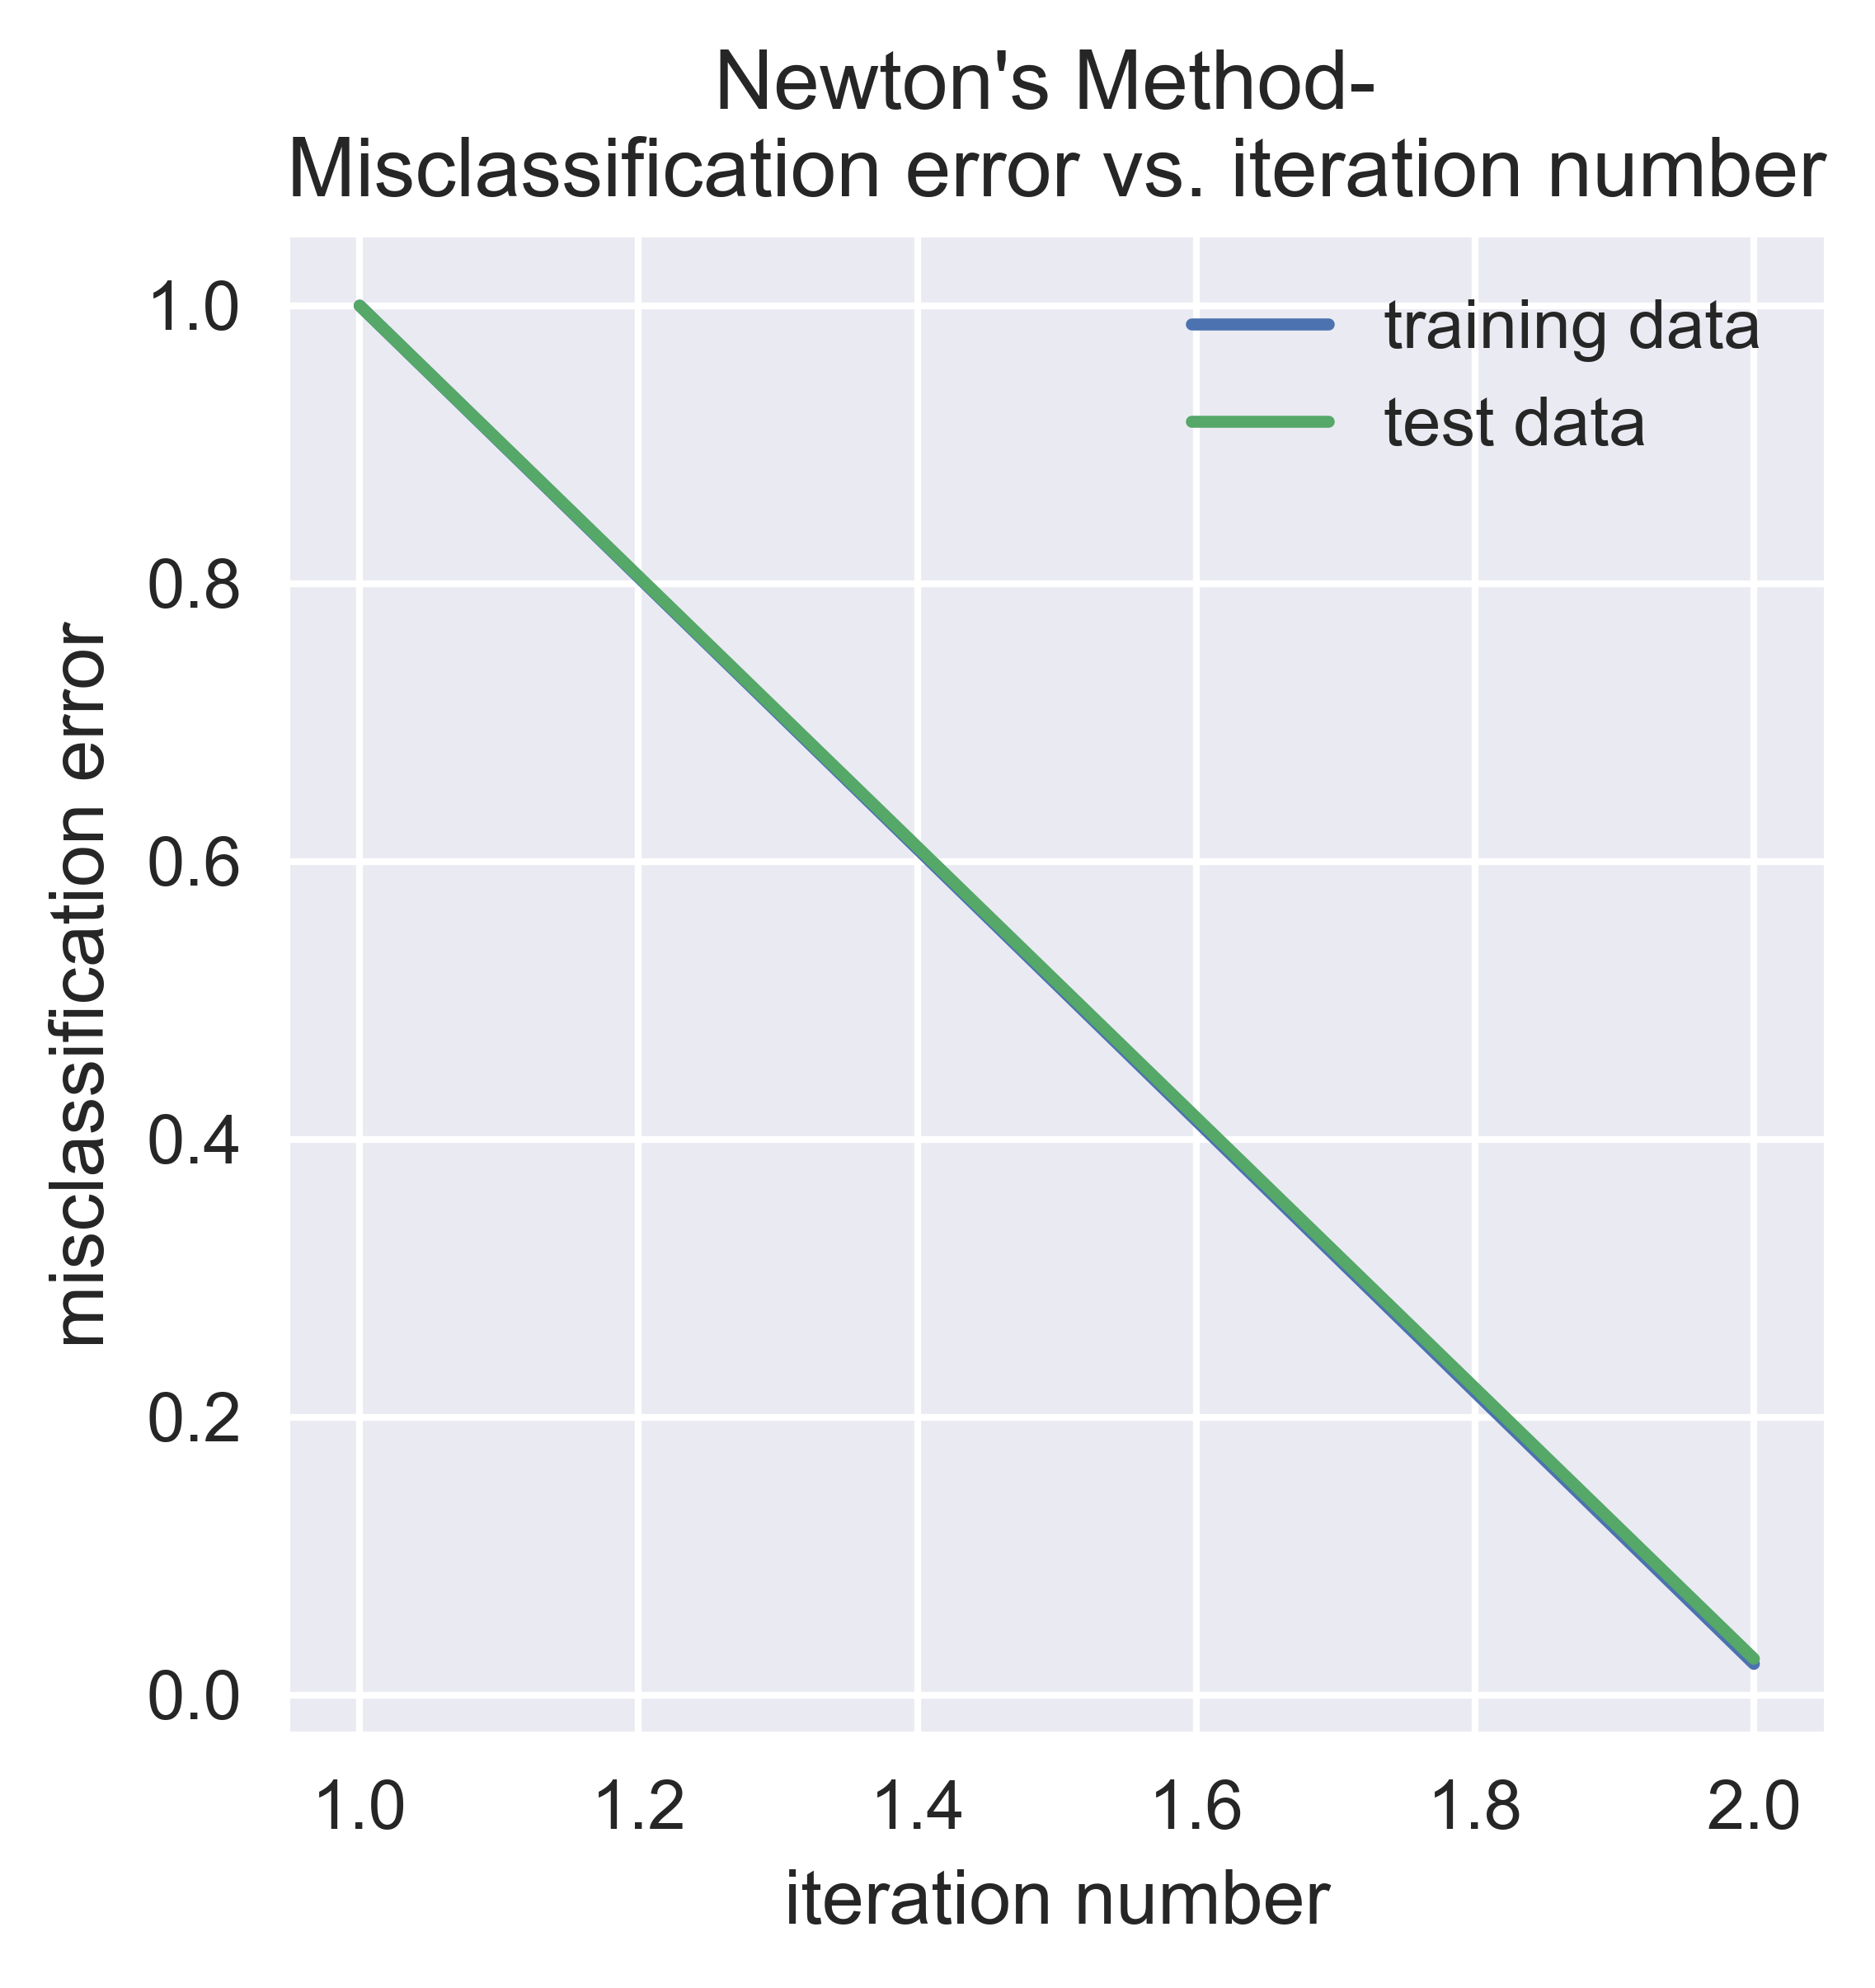

In [20]:
plot_objective_train_test(k_vec,j_train_vec,j_test_vec,train_classify_vec,test_classify_vec,'Newton\'s Method- \n')

### batch

### this is scratch below here

In [ ]:
X = x_train_c
y = labels_train_c
X_test = x_test_c
y_test = labels_test_c

not_conv = True
j_train_vec = []
j_test_vec = []
w_vec = []
b_vec = []
k_vec = []
train_classify_vec = []
test_classify_vec = []

k = 0
#step_size = 1e-3
step_size = 5e-2
criteria_conv = 2e-4

w = np.zeros((np.shape(X)[1],))
b = 0
n = np.shape(X)[0]
#mu_vec = np.zeros((np.shape(X)[0],))
#cost_mu = np.zeros((np.shape(X)[0],))
#range_vec = np.arange(len(mu_vec))
j_prev = 0

while not_conv:
    ##### training part 
    #mu_vec = [1/(1+np.exp(-y[i]*(b+np.dot(X[i,:].T,w)))) for i in range_vec]
    #cost_mu = [(1+np.exp(-y[i]*(b+np.dot(X[i,:].T,w)))) for i in range_vec]
    mu_vec = 1/(1+np.exp(-y.T*(b+np.dot(X,w)))) 
    cost_mu = 1+np.exp(-y.T*(b+np.dot(X,w)))
     
    #g_w = (1/n)*np.dot(X.T,(mu_vec - y)) + 2*lambda_val*w
    #g_b = (1/n)*np.sum(mu_vec-y)
    
    g_w = (1/n)*(np.dot(X.T,(-y*(1-mu_vec)))) + 2*lambda_val*w
    g_b = (1/n)*np.sum(-y*(1-mu_vec))
    
    j_train = (1/n)*(np.sum(np.log(cost_mu))) + lambda_val*np.dot(w.T,w)
    ####### testing part
    
    mu_vec = 1/(1+np.exp(-y_test.T*(b+np.dot(X_test,w)))) 
    cost_mu = 1+np.exp(-y_test.T*(b+np.dot(X_test,w)))
    
    j_test = (1/n)*(np.sum(np.log(cost_mu))) + lambda_val*np.dot(w.T,w)

    # 
    w_new = w - step_size*g_w
    b_new = b - step_size*g_b
    
    w_vec.append(w)
    b_vec.append(b)

    delta_w = np.abs(w-w_old)
    delta_b = np.abs(b-b_old)

    #w = np.array(w)
    w = copy.copy(w_new)
    b = copy.copy(b_new)

    k_vec.append(k)
    j_train_vec.append(j_train)
    j_test_vec.append(j_test)
    
    #### classificaiton
    train_signed = (b+np.dot(X,w))
    test_signed = (b+np.dot(X_test,w))

    train_data_class = np.sign(train_signed)
    test_data_class = np.sign(test_signed)

    train_classify_error_vec = [train_data_class != y]
    test_classify_error_vec = [test_data_class != y_test]
    
    train_classify_error = np.sum(train_classify_error_vec)/n
    test_classify_error = np.sum(test_classify_error_vec)/n
    
    train_classify_vec.append(train_classify_error)
    test_classify_vec.append(test_classify_error)
    
    # check convergence
    if ((1/n)*np.sum(delta_w))<criteria_conv and k>1:
        not_conv = False

    else:
        not_conv = True
        k += 1

    print('the value of j train is {}'.format(j_train))

    #print('the value of delta_w is {}'.format(delta_w))
    #print(mu_vec)
    #print(not_conv)


In [ ]:
plt.figure()
plt.plot(k_vec,j_train_vec,label='training')
plt.plot(k_vec,j_test_vec,label='testing')
plt.xlabel('iteration number')
plt.ylabel('cost function')
plt.title('Cost function vs. iteration')
plt.legend()
index = np.argmin(j_train_vec)
k_best = k_vec[index]
w_best = w_vec[index]


plt.figure()
plt.plot(k_vec,train_classify_vec,label='training data')
plt.plot(k_vec,test_classify_vec,label='test data')
plt.xlabel('iteration number')
plt.ylabel('misclassification error')
plt.title('Misclassification error vs. iteration number')
plt.legend()


In [ ]:
np.diag([1,2,3])

In [37]:
a= [1,2,3,4,5]

In [44]:
a[:-2]

[1, 2, 3]